# Assignment 3

The assignment 3 contains 1 question and the due date is April 28th (Sunday) 23:59PM. If you have trouble in installing tensorflow in your computer, you may consider using Google Colab for this assignment.

## Question 1 How Yelp Uses Deep Learning to Classify Business Photos? (100 points)

Yelp hosts tens of millions of photos uploaded by Yelpers from all around the world. The wide variety of these photos provides a rich window into local businesses, a window we’re only just peeking through today.

One way we’re trying to open that window is by developing a photo understanding system which allows us to create semantic data about individual photographs. The data generated by the system has been powering our recent launch of tabbed photo browsing as well as our first attempts at content-based photo diversification.

You can check more details about Yelp's practices at [here](https://engineeringblog.yelp.com/2015/10/how-we-use-deep-learning-to-classify-business-photos-at-yelp.html)


![food](https://engineeringblog.yelp.com/images/posts/2015-10-14-photo-classification/image02.png)


In this question, you will be asked to building a Photo Classifier.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
import warnings
import time
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# set keras layer initialiser
weight_initializer = tf.keras.initializers.GlorotUniform(seed=42)

Let's first upload the file images.npy and labels.npy and load the images dataset.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
images = np.load('drive/MyDrive/Colab Notebooks/NOVA/ML Notebooks/Assignment 3/images.npy') # SHAPE: (1024, 256, 256, 3) -> (N_SAMPLES, HEIGHT, WIDTH, CHANNELS)
labels = np.load('drive/MyDrive/Colab Notebooks/NOVA/ML Notebooks/Assignment 3/labels.npy') # SHAPE: (1024,) -> (N_SAMPLES,). Label encoded: 0, 1, 2, 3

print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print('Labels match the image at the respective 0 to 1024 position.')

Images shape: (1024, 256, 256, 3)
Labels shape: (1024,)
Labels match the image at the respective 0 to 1024 position.


There are four types of the images on Yelp: Food, Drink, Interior and Exterior

In [5]:
np.unique(labels)

array([0, 1, 2, 3])

We visualize some random images from the dataset below:

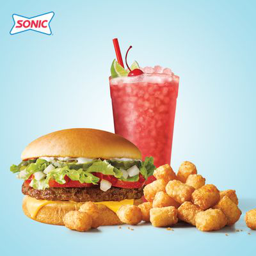

In [6]:
# food: class 0

Image.fromarray(images[5])

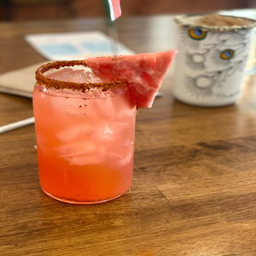

In [7]:
# drink: class 1

Image.fromarray(images[3])

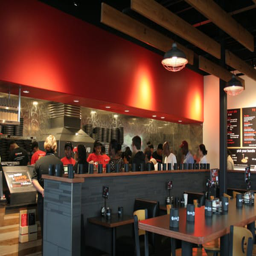

In [8]:
# interior: class 2

Image.fromarray(images[7])

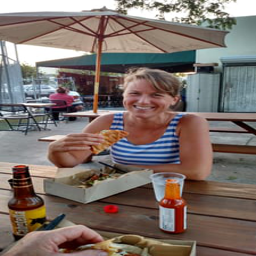

In [9]:
# exterior: class 3

Image.fromarray(images[8])

#### Prepration of the dataset

In [10]:
images_norm = images / 255

In [11]:
# Split the data into training and test sets
images_train_norm, images_test_norm, labels_train, labels_test = train_test_split(
    images_norm, labels, test_size=0.1, random_state=42, stratify=labels)

# Further split the training data into training and validation sets
images_train_norm, images_val_norm, labels_train, labels_val = train_test_split(
    images_train_norm, labels_train, test_size=0.1, random_state=42, stratify=labels_train)

In [12]:
def create_tf_dataset(images, labels, batch_size=32, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if training:
        dataset = dataset.shuffle(buffer_size=10000).batch(batch_size).repeat()
    else:
        dataset = dataset.batch(batch_size)
    return dataset

In [13]:
# Create TensorFlow datasets for training, validation, and testing - for DNN and CNN model (include rescaling of tha data)
train_dataset = create_tf_dataset(images_train_norm, labels_train, batch_size=32, training=True)
val_dataset = create_tf_dataset(images_val_norm, labels_val, batch_size=32, training=False)
test_dataset = create_tf_dataset(images_test_norm, labels_test, batch_size=32, training=False)

In [14]:
# Split the data into training and test sets
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.1, random_state=42, stratify=labels)

# Further split the training data into training and validation sets
images_train, images_val, labels_train, labels_val = train_test_split(
    images_train, labels_train, test_size=0.1, random_state=42, stratify=labels_train)

# Crate TensorFlow datasets for train, vla and test - for pre-trained model (transfer learning), without any preprocessing
train_dataset_nopreproc = create_tf_dataset(images_train, labels_train, batch_size=32, training=True)
val_dataset_nopreproc = create_tf_dataset(images_val, labels_val, batch_size=32, training=False)
test_dataset_nopreproc = create_tf_dataset(images_test, labels_test, batch_size=32, training=False)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

train_dataset_nopreproc = train_dataset_nopreproc.prefetch(buffer_size=AUTOTUNE)
val_dataset_nopreproc = val_dataset_nopreproc.prefetch(buffer_size=AUTOTUNE)
test_dataset_nopreproc = test_dataset_nopreproc.prefetch(buffer_size=AUTOTUNE)

### Question 1.1 Training a deep neural network (15 points)

Practice training a deep neural network on the Yelp image dataset


Build a Deep Neural Network (DNN) with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this question), using the RELU activation function.

Using Adam optimization, train the network on the dataset. Donot forget define your input and output layers.

Train the model for 100 epochs and use test set as the validation data during the training, explain how many parameters does the model have and whether the model will experience overfitting. You may consider plotting the losses and accuracy over epochs.

#### Handle Functions For the Models

In [16]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


def train_model(model, train_dataset, val_dataset, epochs=100):
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        steps_per_epoch=len(images_train) // 32,
        validation_steps=len(images_val) // 32
    )
    return history


def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Show the plot
    plt.show()

    # Print final loss and accuracy statistics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    print(f"\nFinal Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


def evaluate_model(model, test_dataset):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    return test_loss, test_accuracy

#### Utility functions for models benchmarking

In [17]:
def log_model_results(df, config_description, history, test_loss, test_accuracy, total_time, avg_time_per_epoch):
    """Log the model results and configuration to the provided DataFrame, including training time metrics.

    Args:
        df (pd.DataFrame): The DataFrame to log results to.
        config_description (str): A description of the model configuration.
        history (History): The training history object from Keras.
        test_loss (float): Loss on the test dataset.
        test_accuracy (float): Accuracy on the test dataset.
        total_time (float): Total training time in seconds.
        avg_time_per_epoch (float): Average time per epoch in seconds.

    Returns:
        pd.DataFrame: Updated DataFrame with the new log entry.
    """
    # Extract final training and validation loss and accuracy
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]

    # Append new row to DataFrame
    new_row = {
        'Configuration': config_description,
        'Final Train Loss': final_train_loss,
        'Final Validation Loss': final_val_loss,
        'Final Train Accuracy': final_train_accuracy,
        'Final Validation Accuracy': final_val_accuracy,
        'Test Loss': test_loss,
        'Test Accuracy': test_accuracy,
        'Total Training Time (s)': total_time,
        'Average Time per Epoch (s)': avg_time_per_epoch
    }

    return pd.concat([df, pd.DataFrame([new_row])])


def full_model_evaluation(create_model_func, config_description, train_dataset, val_dataset, test_dataset, epochs=100, batch_size=32, callbacks=None, results_df=None):
    """
    Trains the model, evaluates, plots training history, logs results, and optionally handles callbacks.

    Args:
        create_model_func (function): Function to create and return the model.
        config_description (str): Description of the model configuration.
        train_dataset (tf.data.Dataset): The training dataset.
        val_dataset (tf.data.Dataset): The validation dataset.
        test_dataset (tf.data.Dataset): The test dataset.
        epochs (int): Number of epochs to train.
        batch_size (int): number of batches in one epoch.
        callbacks (list): list of callbacks
        results_df (pd.DataFrame): DataFrame to log results to. If None, initializes a new DataFrame.


    Returns:
        restult_df (pd.DataFrame): The updated or newly created DataFrame containing the results.
        model (keras.model): keras model
    """
    # Initialize results DataFrame if none provided
    if results_df is None:
        results_df = pd.DataFrame(columns=[
            'Configuration',
            'Final Train Loss',
            'Final Validation Loss',
            'Final Train Accuracy',
            'Final Validation Accuracy',
            'Test Loss',
            'Test Accuracy',
            'Total Training Time (s)',
            'Average Time per Epoch (s)'
        ])

    # Create and compile the model
    model = create_model_func()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Calculate steps per epoch and validation steps
    steps_per_epoch = len(images_train) // batch_size
    validation_steps = len(images_val) // batch_size

    start_time = time.time()
    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    end_time = time.time()
    total_training_time = end_time - start_time

    actual_epochs_completed = len(history.history['loss'])
    average_time_per_epoch = total_training_time / actual_epochs_completed

    # Plot the training history
    plot_history(history)

    # Evaluate the model on the test dataset
    test_loss, test_accuracy = evaluate_model(model, test_dataset)

    # Log the results
    results_df = log_model_results(
        results_df,
        config_description,
        history,
        test_loss,
        test_accuracy,
        total_training_time,
        average_time_per_epoch
    ).reset_index(drop=True)

    # Return the updated DataFrame
    return results_df, model

#### Benchmark Model (Simple Dense Neural Net)

In [18]:
def build_basic_model(input_shape, num_layers, num_classes):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape))
    # Flatten the input to a 1D vector before passing it to the Dense layers
    model.add(keras.layers.Flatten())
    for _ in range(num_layers):
        model.add(keras.layers.Dense(100, activation='relu', kernel_initializer=weight_initializer))
    model.add(keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=weight_initializer))
    return model

Epoch 1/100
25/25 [==============================] - 4s 84ms/step - loss: 16.8373 - accuracy: 0.3137 - val_loss: 4.9061 - val_accuracy: 0.3906
Epoch 2/100
25/25 [==============================] - 1s 55ms/step - loss: 6.2153 - accuracy: 0.3706 - val_loss: 3.8185 - val_accuracy: 0.3906
Epoch 3/100
25/25 [==============================] - 1s 44ms/step - loss: 6.4826 - accuracy: 0.3832 - val_loss: 9.2714 - val_accuracy: 0.2969
Epoch 4/100
25/25 [==============================] - 1s 58ms/step - loss: 3.7817 - accuracy: 0.4862 - val_loss: 4.1751 - val_accuracy: 0.4531
Epoch 5/100
25/25 [==============================] - 2s 66ms/step - loss: 1.7063 - accuracy: 0.6256 - val_loss: 1.7875 - val_accuracy: 0.5469
Epoch 6/100
25/25 [==============================] - 1s 60ms/step - loss: 2.6478 - accuracy: 0.5276 - val_loss: 4.5840 - val_accuracy: 0.3906
Epoch 7/100
25/25 [==============================] - 1s 44ms/step - loss: 2.8375 - accuracy: 0.5364 - val_loss: 4.1318 - val_accuracy: 0.3594
Epoch

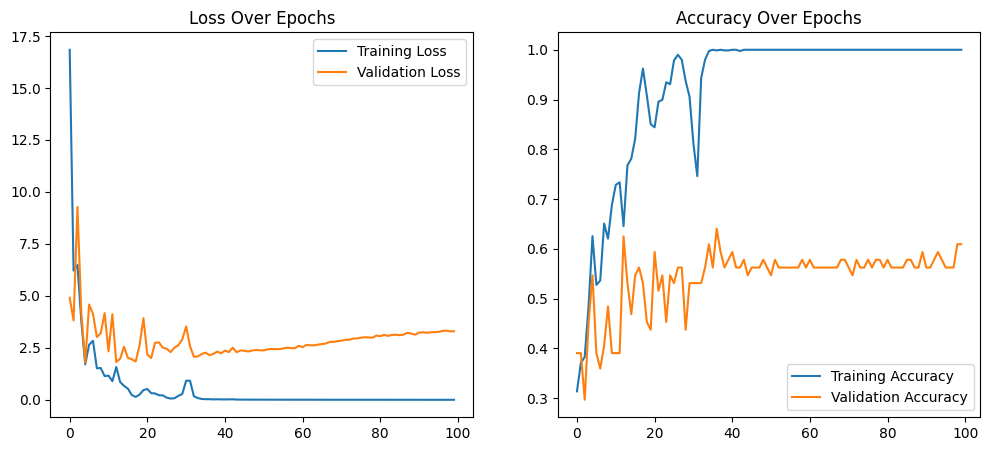


Final Training Loss: 0.0007
Final Validation Loss: 3.2982
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.6094
4/4 [==============================] - 0s 37ms/step - loss: 3.7542 - accuracy: 0.4660
Test Loss: 3.754167079925537, Test Accuracy: 0.4660194218158722


In [19]:
epochs = 100
batch_size = 32

# Create and evaluate the baseline model + initialize the results dataframe
results_df, model_benchmark = full_model_evaluation(
    create_model_func=lambda: build_basic_model(input_shape=(256, 256, 3), num_layers=2, num_classes=4),
    config_description="Baseline Model",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size
)

### Question 1.2 (25 points)

Try reduce the overfitting and improve the model performance. You can try the bag of tricks to the model from the class. This may include one or more techniques such as **weight regularization**, **batch normalization**, **dropout**, **Early stopping**, etc. You should perform ``ablation study``, a common techniqued used in machine learning community to show the effectivess of the introduced technique. In other words, show your step-by-step improvement by including these techniques and repeat the repeat the previous training process. Explain whether and how these techniques help achieve a better result. You may consider stopping improving the model by making it at least 10% better than the previous model architecture.

In [20]:
baseline_loss, baseline_acc = evaluate_model(model_benchmark, test_dataset)

# calculate improvement needed to achieve by ablation study
needed_improvement = baseline_acc + 0.1 * baseline_acc

print(f'''\n\n\nThe baseline model (Dense Neural Network) trained on 100 epochs achieved accuracy of {round(baseline_acc * 100, 2)}

The Goal of ablation study is to find a model that performs 10% better than the baseline model.
Hence, the seeked accuracy must be at least {round(needed_improvement * 100, 2)}
''')

4/4 [==============================] - 0s 25ms/step - loss: 3.7542 - accuracy: 0.4660
Test Loss: 3.754167079925537, Test Accuracy: 0.4660194218158722
The baseline model (Dense Neural Network) trained on 100 epochs achieved accuracy of 46.6

The Goal of ablation study is to find a model that performs 10% better than the baseline model.
Hence, the seeked accuracy must be at least 51.26



#### Weight Regularization

In [21]:
# L1 regularization
def build_model_with_l1(input_shape, num_layers, num_classes, l1_factor=0.001):
    """
    Builds a Sequential model with L1 regularization on each Dense layer.

    Args:
        input_shape (tuple): Shape of the input data (excluding batch size).
        num_layers (int): Number of Dense layers in the model.
        num_classes (int): Number of output classes.
        l1_factor (float): L1 regularization factor.

    Returns:
        keras.models.Model: Compiled Keras model with L1 regularization.
    """
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape))
    model.add(keras.layers.Flatten())
    for _ in range(num_layers):
        model.add(keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l1(l1_factor), kernel_initializer=weight_initializer))
    model.add(keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=weight_initializer))
    return model

Epoch 1/100
25/25 [==============================] - 8s 81ms/step - loss: 28.6167 - accuracy: 0.2375 - val_loss: 17.9548 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 2s 83ms/step - loss: 15.0020 - accuracy: 0.2324 - val_loss: 12.6107 - val_accuracy: 0.2812
Epoch 3/100
25/25 [==============================] - 2s 71ms/step - loss: 10.9012 - accuracy: 0.2362 - val_loss: 9.4666 - val_accuracy: 0.2656
Epoch 4/100
25/25 [==============================] - 2s 62ms/step - loss: 8.1377 - accuracy: 0.2412 - val_loss: 7.0518 - val_accuracy: 0.2500
Epoch 5/100
25/25 [==============================] - 1s 50ms/step - loss: 6.1080 - accuracy: 0.2437 - val_loss: 5.4426 - val_accuracy: 0.2500
Epoch 6/100
25/25 [==============================] - 1s 53ms/step - loss: 4.8026 - accuracy: 0.2437 - val_loss: 4.3914 - val_accuracy: 0.2031
Epoch 7/100
25/25 [==============================] - 1s 51ms/step - loss: 4.1459 - accuracy: 0.2198 - val_loss: 4.1856 - val_accuracy: 0.2656
E

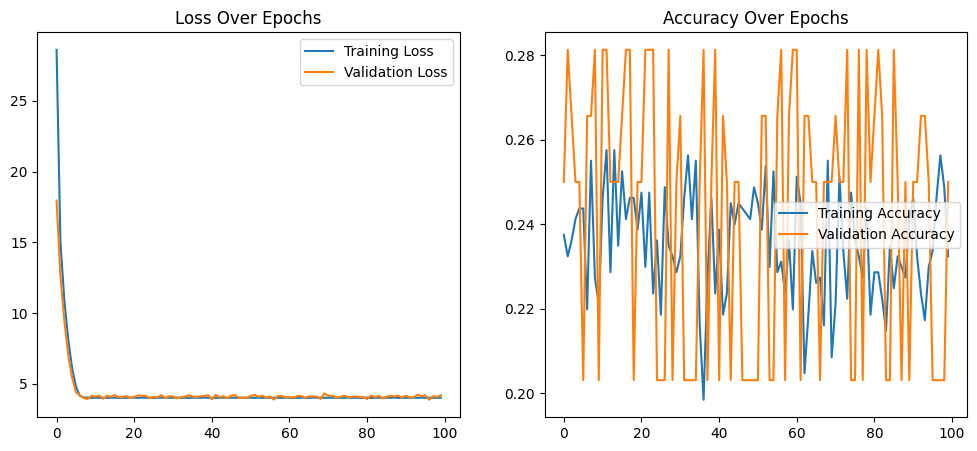


Final Training Loss: 4.0197
Final Validation Loss: 4.1992
Final Training Accuracy: 0.2324
Final Validation Accuracy: 0.2500
4/4 [==============================] - 0s 28ms/step - loss: 4.1992 - accuracy: 0.2427
Test Loss: 4.199182987213135, Test Accuracy: 0.24271844327449799


In [22]:
epochs = 100
batch_size = 32

# Create and evaluate the model with L1 regularization
results_df, model_l1 = full_model_evaluation(
    create_model_func=lambda: build_model_with_l1((256, 256, 3), 20, 4, l1_factor=0.001),
    config_description="Model with L1 Regularization (0.001)",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df
)


Epoch 1/100
25/25 [==============================] - 8s 65ms/step - loss: 273.5322 - accuracy: 0.2350 - val_loss: 166.6705 - val_accuracy: 0.2812
Epoch 2/100
25/25 [==============================] - 1s 50ms/step - loss: 137.6318 - accuracy: 0.2236 - val_loss: 113.8988 - val_accuracy: 0.2500
Epoch 3/100
25/25 [==============================] - 1s 50ms/step - loss: 96.9314 - accuracy: 0.2312 - val_loss: 82.7096 - val_accuracy: 0.2812
Epoch 4/100
25/25 [==============================] - 1s 50ms/step - loss: 69.2794 - accuracy: 0.2274 - val_loss: 58.6223 - val_accuracy: 0.2031
Epoch 5/100
25/25 [==============================] - 1s 50ms/step - loss: 48.9802 - accuracy: 0.2312 - val_loss: 42.5785 - val_accuracy: 0.2500
Epoch 6/100
25/25 [==============================] - 1s 49ms/step - loss: 35.9596 - accuracy: 0.2425 - val_loss: 32.2240 - val_accuracy: 0.2031
Epoch 7/100
25/25 [==============================] - 2s 82ms/step - loss: 29.3926 - accuracy: 0.2450 - val_loss: 29.8241 - val_accur

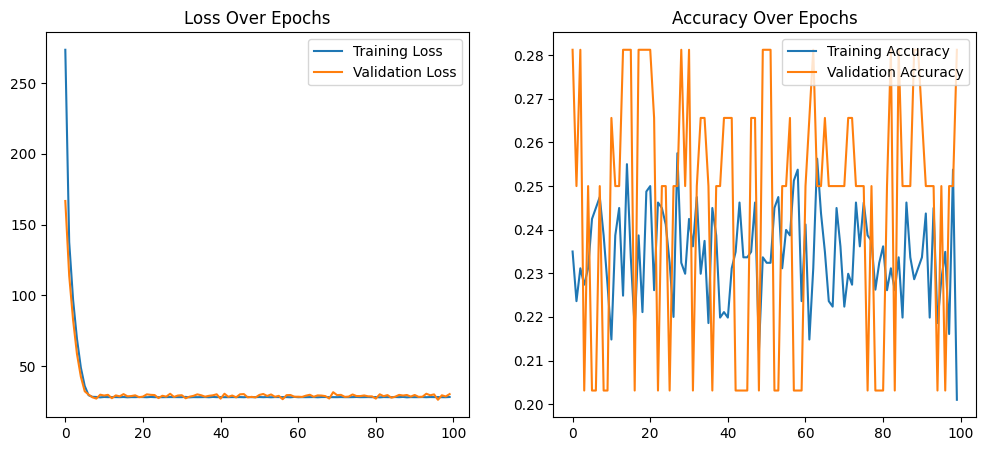


Final Training Loss: 28.1462
Final Validation Loss: 30.2119
Final Training Accuracy: 0.2010
Final Validation Accuracy: 0.2812
4/4 [==============================] - 0s 28ms/step - loss: 30.2119 - accuracy: 0.2524
Test Loss: 30.211896896362305, Test Accuracy: 0.25242719054222107


In [23]:

results_df, model_l1_01 = full_model_evaluation(
    create_model_func=lambda: build_model_with_l1((256, 256, 3), 20, 4, l1_factor=0.01),
    config_description="Model with L1 Regularization (0.01)",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df
)

In [24]:
# L2 Regularization
def build_model_with_l2(input_shape, num_layers, num_classes, l2_factor=0.01):
    """
    Builds a Sequential model with L2 regularization on each Dense layer.

    Args:
        input_shape (tuple): Shape of the input data (excluding batch size).
        num_layers (int): Number of Dense layers in the model.
        num_classes (int): Number of output classes.
        l2_factor (float): L2 regularization factor.

    Returns:
        keras.models.Model: Compiled Keras model with L1 regularization.
    """
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape))
    model.add(keras.layers.Flatten())
    for _ in range(num_layers):
        model.add(keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_factor), kernel_initializer=weight_initializer))
    model.add(keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=weight_initializer))
    return model

Epoch 1/100
25/25 [==============================] - 8s 65ms/step - loss: 28.6152 - accuracy: 0.2425 - val_loss: 17.9712 - val_accuracy: 0.2812
Epoch 2/100
25/25 [==============================] - 1s 51ms/step - loss: 14.9931 - accuracy: 0.2286 - val_loss: 12.5977 - val_accuracy: 0.2656
Epoch 3/100
25/25 [==============================] - 1s 50ms/step - loss: 10.8760 - accuracy: 0.2186 - val_loss: 9.4237 - val_accuracy: 0.2812
Epoch 4/100
25/25 [==============================] - 1s 52ms/step - loss: 8.1123 - accuracy: 0.2425 - val_loss: 7.0202 - val_accuracy: 0.2500
Epoch 5/100
25/25 [==============================] - 1s 53ms/step - loss: 6.0832 - accuracy: 0.2525 - val_loss: 5.3962 - val_accuracy: 0.2812
Epoch 6/100
25/25 [==============================] - 1s 59ms/step - loss: 4.7757 - accuracy: 0.2236 - val_loss: 4.3538 - val_accuracy: 0.2812
Epoch 7/100
25/25 [==============================] - 2s 84ms/step - loss: 4.1199 - accuracy: 0.2475 - val_loss: 4.1511 - val_accuracy: 0.2031
E

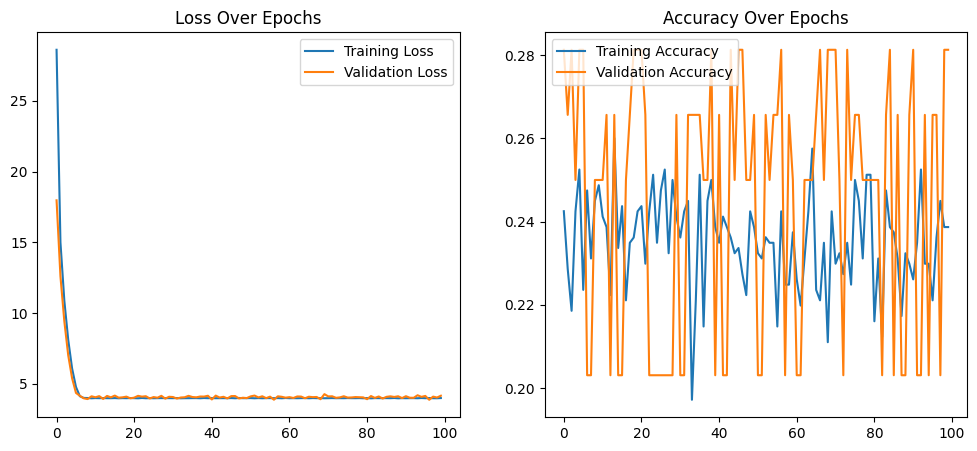


Final Training Loss: 3.9912
Final Validation Loss: 4.1559
Final Training Accuracy: 0.2387
Final Validation Accuracy: 0.2812
4/4 [==============================] - 0s 26ms/step - loss: 4.1561 - accuracy: 0.2524
Test Loss: 4.1560516357421875, Test Accuracy: 0.25242719054222107


In [25]:
epochs = 100
batch_size = 32

# Create and evaluate the model with L1 regularization
results_df, model_l2_001 = full_model_evaluation(
    create_model_func=lambda: build_model_with_l1((256, 256, 3), 20, 4, l1_factor=0.001),
    config_description="Model with L2 Regularization (0.001)",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df
)

Epoch 1/100
25/25 [==============================] - 8s 64ms/step - loss: 273.5307 - accuracy: 0.2212 - val_loss: 166.6703 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 1s 54ms/step - loss: 137.6231 - accuracy: 0.2550 - val_loss: 113.8819 - val_accuracy: 0.2812
Epoch 3/100
25/25 [==============================] - 1s 53ms/step - loss: 96.9176 - accuracy: 0.2261 - val_loss: 82.7059 - val_accuracy: 0.2656
Epoch 4/100
25/25 [==============================] - 1s 51ms/step - loss: 69.2700 - accuracy: 0.2186 - val_loss: 58.6065 - val_accuracy: 0.2812
Epoch 5/100
25/25 [==============================] - 1s 50ms/step - loss: 48.9735 - accuracy: 0.2299 - val_loss: 42.5568 - val_accuracy: 0.2500
Epoch 6/100
25/25 [==============================] - 1s 56ms/step - loss: 35.9505 - accuracy: 0.2525 - val_loss: 32.2021 - val_accuracy: 0.2812
Epoch 7/100
25/25 [==============================] - 1s 52ms/step - loss: 29.3841 - accuracy: 0.2224 - val_loss: 29.8142 - val_accur

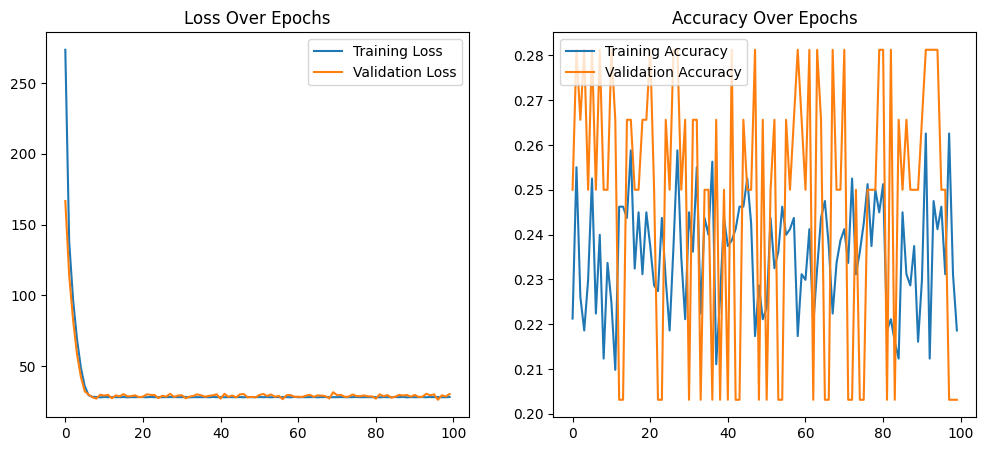


Final Training Loss: 28.1392
Final Validation Loss: 30.1973
Final Training Accuracy: 0.2186
Final Validation Accuracy: 0.2031
4/4 [==============================] - 0s 27ms/step - loss: 30.1973 - accuracy: 0.2524
Test Loss: 30.197267532348633, Test Accuracy: 0.25242719054222107


In [26]:
results_df, model_l2_01 = full_model_evaluation(
    create_model_func=lambda: build_model_with_l1((256, 256, 3), 20, 4, l1_factor=0.01),
    config_description="Model with L2 Regularization (0.01)",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df
)

In [27]:
results_df

,Configuration,Final Train Loss,Final Validation Loss,Final Train Accuracy,Final Validation Accuracy,Test Loss,Test Accuracy,Total Training Time (s),Average Time per Epoch (s)
0,Baseline Model,0.000719,3.298196,1.000000,0.609375,3.754167,0.466019,133.340943,1.333409
1,Model with L1 Regularization (0.001),4.019690,4.199212,0.232412,0.250000,4.199183,0.242718,157.656868,1.576569
2,Model with L1 Regularization (0.01),28.146200,30.211891,0.201005,0.281250,30.211897,0.252427,150.499986,1.505000
3,Model with L2 Regularization (0.001),3.991182,4.155935,0.238693,0.281250,4.156052,0.252427,148.454952,1.484550
4,Model with L2 Regularization (0.01),28.139238,30.197332,0.218593,0.203125,30.197268,0.252427,148.498567,1.484986


#### Batch Normlisation

In [28]:
def build_model_with_batch_norm(input_shape, num_layers, num_classes):
    """
    Builds a Sequential model with Batch Normalization after each Dense layer.

    Args:
        input_shape (tuple): Shape of the input data (excluding batch size).
        num_layers (int): Number of Dense layers in the model.
        num_classes (int): Number of output classes.

    Returns:
        keras.models.Model: Compiled Keras model with Batch Normalization.
    """
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape))
    model.add(keras.layers.Flatten())
    for _ in range(num_layers):
        model.add(keras.layers.Dense(100, activation='relu', kernel_initializer=weight_initializer))
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=weight_initializer))
    return model

Epoch 1/100
25/25 [==============================] - 16s 85ms/step - loss: 1.8584 - accuracy: 0.2925 - val_loss: 1.3438 - val_accuracy: 0.2656
Epoch 2/100
25/25 [==============================] - 2s 66ms/step - loss: 1.6816 - accuracy: 0.2789 - val_loss: 1.3586 - val_accuracy: 0.2656
Epoch 3/100
25/25 [==============================] - 2s 94ms/step - loss: 1.5837 - accuracy: 0.2814 - val_loss: 1.3908 - val_accuracy: 0.2344
Epoch 4/100
25/25 [==============================] - 2s 87ms/step - loss: 1.4772 - accuracy: 0.3191 - val_loss: 1.3955 - val_accuracy: 0.2500
Epoch 5/100
25/25 [==============================] - 2s 67ms/step - loss: 1.5583 - accuracy: 0.2802 - val_loss: 1.3895 - val_accuracy: 0.1562
Epoch 6/100
25/25 [==============================] - 2s 66ms/step - loss: 1.5150 - accuracy: 0.2864 - val_loss: 1.3605 - val_accuracy: 0.2188
Epoch 7/100
25/25 [==============================] - 2s 66ms/step - loss: 1.4994 - accuracy: 0.2638 - val_loss: 1.3366 - val_accuracy: 0.2344
Epoch

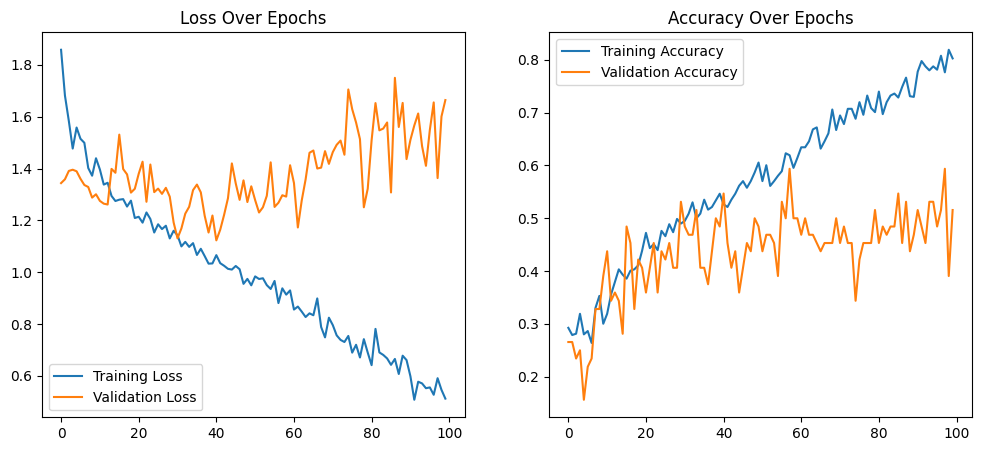


Final Training Loss: 0.5120
Final Validation Loss: 1.6643
Final Training Accuracy: 0.8028
Final Validation Accuracy: 0.5156
4/4 [==============================] - 0s 43ms/step - loss: 1.7858 - accuracy: 0.4951
Test Loss: 1.785822868347168, Test Accuracy: 0.49514561891555786


In [29]:
epochs = 100
batch_size = 32

results_df, model_batch_norm = full_model_evaluation(
    create_model_func=lambda: build_model_with_batch_norm((256, 256, 3), 20, 4),
    config_description="Model with batch normalization",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df
)

In [30]:
results_df

,Configuration,Final Train Loss,Final Validation Loss,Final Train Accuracy,Final Validation Accuracy,Test Loss,Test Accuracy,Total Training Time (s),Average Time per Epoch (s)
0,Baseline Model,0.000719,3.298196,1.000000,0.609375,3.754167,0.466019,133.340943,1.333409
1,Model with L1 Regularization (0.001),4.019690,4.199212,0.232412,0.250000,4.199183,0.242718,157.656868,1.576569
2,Model with L1 Regularization (0.01),28.146200,30.211891,0.201005,0.281250,30.211897,0.252427,150.499986,1.505000
3,Model with L2 Regularization (0.001),3.991182,4.155935,0.238693,0.281250,4.156052,0.252427,148.454952,1.484550
4,Model with L2 Regularization (0.01),28.139238,30.197332,0.218593,0.203125,30.197268,0.252427,148.498567,1.484986
5,Model with batch normalization,0.511984,1.664261,0.802764,0.515625,1.785823,0.495146,196.073616,1.960736


#### Dropout

In [31]:
def build_model_with_dropout(input_shape, num_layers, num_classes, dropout_rate=0.5):
    """
    Builds a Sequential model with Dropout applied after each Dense layer.

    Args:
        input_shape (tuple): Shape of the input data (excluding batch size).
        num_layers (int): Number of Dense layers in the model.
        num_classes (int): Number of output classes.
        dropout_rate (float): Dropout rate, fraction of the input units to drop.

    Returns:
        keras.models.Model: Compiled Keras model with Dropout layers.
    """
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape))
    model.add(keras.layers.Flatten())
    for _ in range(num_layers):
        model.add(keras.layers.Dense(100, activation='relu', kernel_initializer=weight_initializer))
        model.add(keras.layers.Dropout(dropout_rate, seed=42))  # Add dropout layer after the activation
    model.add(keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=weight_initializer))
    return model

Epoch 1/100
25/25 [==============================] - 9s 61ms/step - loss: 264.7571 - accuracy: 0.2713 - val_loss: 1.3893 - val_accuracy: 0.2031
Epoch 2/100
25/25 [==============================] - 1s 50ms/step - loss: 1.9748 - accuracy: 0.2399 - val_loss: 1.3889 - val_accuracy: 0.2031
Epoch 3/100
25/25 [==============================] - 2s 77ms/step - loss: 1.4233 - accuracy: 0.2550 - val_loss: 1.3892 - val_accuracy: 0.2031
Epoch 4/100
25/25 [==============================] - 2s 73ms/step - loss: 1.3855 - accuracy: 0.2387 - val_loss: 1.3891 - val_accuracy: 0.2031
Epoch 5/100
25/25 [==============================] - 1s 57ms/step - loss: 1.3867 - accuracy: 0.2525 - val_loss: 1.3889 - val_accuracy: 0.2031
Epoch 6/100
25/25 [==============================] - 1s 48ms/step - loss: 1.4156 - accuracy: 0.2412 - val_loss: 1.3886 - val_accuracy: 0.2031
Epoch 7/100
25/25 [==============================] - 1s 52ms/step - loss: 1.3867 - accuracy: 0.2399 - val_loss: 1.3881 - val_accuracy: 0.2031
Epoc

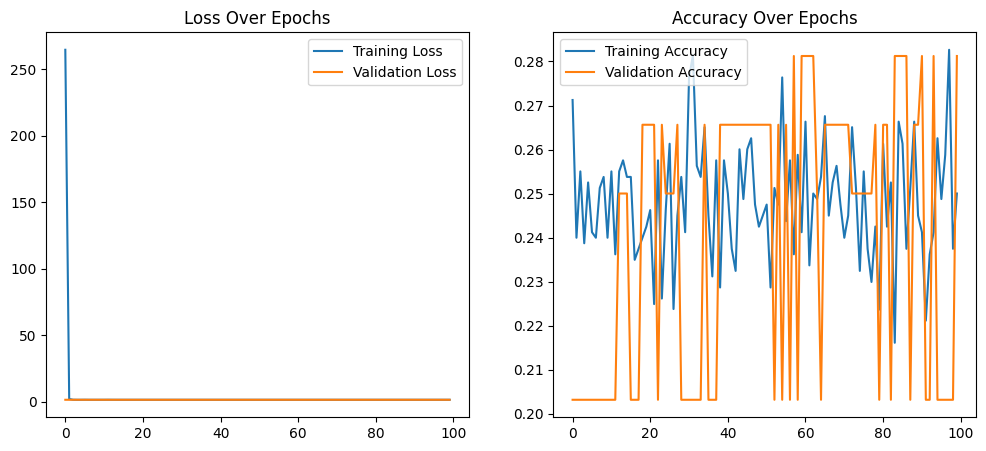


Final Training Loss: 1.3873
Final Validation Loss: 1.3860
Final Training Accuracy: 0.2500
Final Validation Accuracy: 0.2812
4/4 [==============================] - 0s 27ms/step - loss: 1.3863 - accuracy: 0.2524
Test Loss: 1.3862781524658203, Test Accuracy: 0.25242719054222107


In [32]:
epochs = 100
batch_size = 32

results_df, model_dropout_0_5 = full_model_evaluation(
    create_model_func=lambda: build_model_with_dropout((256, 256, 3), 20, 4, dropout_rate=0.5),
    config_description="Model with dropout (0.5)",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df
)

Epoch 1/100
25/25 [==============================] - 8s 61ms/step - loss: 10.1300 - accuracy: 0.2113 - val_loss: 1.3880 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 1s 52ms/step - loss: 1.5586 - accuracy: 0.2362 - val_loss: 1.3862 - val_accuracy: 0.2500
Epoch 3/100
25/25 [==============================] - 1s 52ms/step - loss: 1.4120 - accuracy: 0.2224 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 4/100
25/25 [==============================] - 1s 50ms/step - loss: 1.3864 - accuracy: 0.2425 - val_loss: 1.3857 - val_accuracy: 0.2500
Epoch 5/100
25/25 [==============================] - 1s 51ms/step - loss: 1.3946 - accuracy: 0.2626 - val_loss: 1.3856 - val_accuracy: 0.2812
Epoch 6/100
25/25 [==============================] - 1s 49ms/step - loss: 1.3862 - accuracy: 0.2802 - val_loss: 1.3856 - val_accuracy: 0.2812
Epoch 7/100
25/25 [==============================] - 2s 80ms/step - loss: 1.3879 - accuracy: 0.2651 - val_loss: 1.3858 - val_accuracy: 0.2812
Epoch

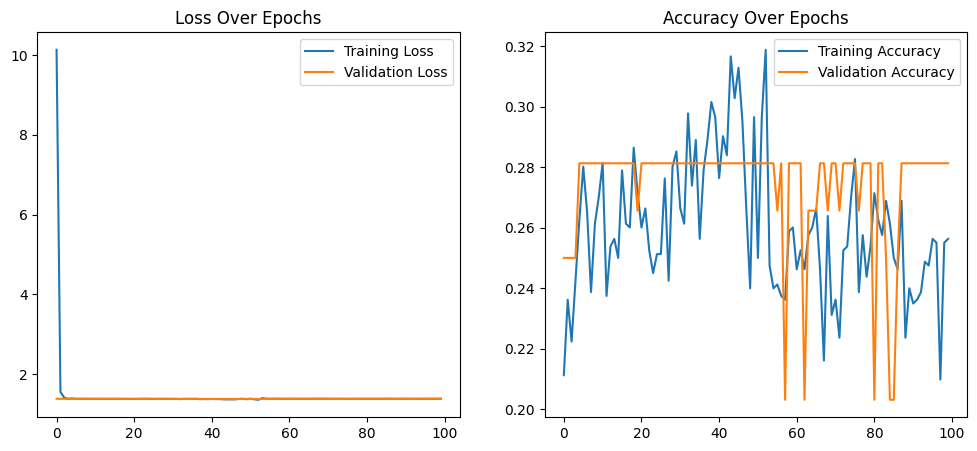


Final Training Loss: 1.3871
Final Validation Loss: 1.3858
Final Training Accuracy: 0.2563
Final Validation Accuracy: 0.2812
4/4 [==============================] - 0s 25ms/step - loss: 1.3862 - accuracy: 0.2524
Test Loss: 1.3862348794937134, Test Accuracy: 0.25242719054222107


In [33]:
results_df, model_dropout_0_35 = full_model_evaluation(
    create_model_func=lambda: build_model_with_dropout((256, 256, 3), 20, 4, dropout_rate=0.35),
    config_description="Model with dropout (0.35)",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df
)

Epoch 1/100
25/25 [==============================] - 9s 94ms/step - loss: 2.3536 - accuracy: 0.2488 - val_loss: 1.3882 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 1s 47ms/step - loss: 1.3926 - accuracy: 0.2437 - val_loss: 1.3873 - val_accuracy: 0.2500
Epoch 3/100
25/25 [==============================] - 1s 49ms/step - loss: 1.3830 - accuracy: 0.2688 - val_loss: 1.3855 - val_accuracy: 0.2344
Epoch 4/100
25/25 [==============================] - 1s 50ms/step - loss: 1.3868 - accuracy: 0.2676 - val_loss: 1.3854 - val_accuracy: 0.2500
Epoch 5/100
25/25 [==============================] - 1s 49ms/step - loss: 1.3902 - accuracy: 0.2425 - val_loss: 1.3832 - val_accuracy: 0.3750
Epoch 6/100
25/25 [==============================] - 1s 50ms/step - loss: 1.3889 - accuracy: 0.2588 - val_loss: 1.3861 - val_accuracy: 0.2812
Epoch 7/100
25/25 [==============================] - 1s 50ms/step - loss: 1.3843 - accuracy: 0.2676 - val_loss: 1.3825 - val_accuracy: 0.3125
Epoch 

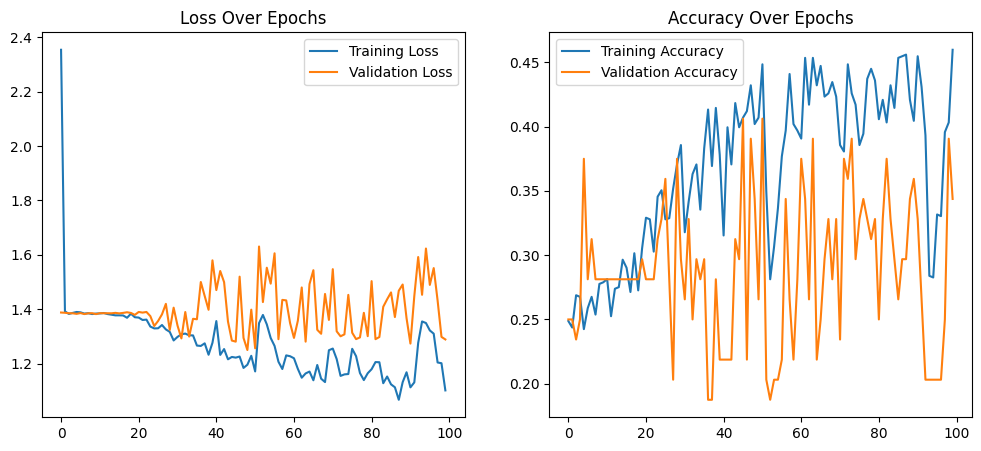


Final Training Loss: 1.1020
Final Validation Loss: 1.2893
Final Training Accuracy: 0.4598
Final Validation Accuracy: 0.3438
4/4 [==============================] - 0s 38ms/step - loss: 1.3207 - accuracy: 0.3204
Test Loss: 1.3207112550735474, Test Accuracy: 0.3203883469104767


In [34]:
results_df, model_dropout_0_2 = full_model_evaluation(
    create_model_func=lambda: build_model_with_dropout((256, 256, 3), 20, 4, dropout_rate=0.2),
    config_description="Model with dropout (0.2)",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df
)

In [35]:
results_df

,Configuration,Final Train Loss,Final Validation Loss,Final Train Accuracy,Final Validation Accuracy,Test Loss,Test Accuracy,Total Training Time (s),Average Time per Epoch (s)
0,Baseline Model,0.000719,3.298196,1.000000,0.609375,3.754167,0.466019,133.340943,1.333409
1,Model with L1 Regularization (0.001),4.019690,4.199212,0.232412,0.250000,4.199183,0.242718,157.656868,1.576569
2,Model with L1 Regularization (0.01),28.146200,30.211891,0.201005,0.281250,30.211897,0.252427,150.499986,1.505000
3,Model with L2 Regularization (0.001),3.991182,4.155935,0.238693,0.281250,4.156052,0.252427,148.454952,1.484550
4,Model with L2 Regularization (0.01),28.139238,30.197332,0.218593,0.203125,30.197268,0.252427,148.498567,1.484986
5,Model with batch normalization,0.511984,1.664261,0.802764,0.515625,1.785823,0.495146,196.073616,1.960736
6,Model with dropout (0.5),1.387294,1.386011,0.250000,0.281250,1.386278,0.252427,205.491993,2.054920
7,Model with dropout (0.35),1.387076,1.385794,0.256281,0.281250,1.386235,0.252427,205.778939,2.057789
8,Model with dropout (0.2),1.101971,1.289256,0.459799,0.343750,1.320711,0.320388,204.991889,2.049919


#### Early Stopping

In [36]:
# Setup EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

Epoch 1/100
25/25 [==============================] - 7s 73ms/step - loss: 1.4124 - accuracy: 0.2500 - val_loss: 1.3877 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 1s 55ms/step - loss: 1.3799 - accuracy: 0.2462 - val_loss: 1.3759 - val_accuracy: 0.2500
Epoch 3/100
25/25 [==============================] - 1s 56ms/step - loss: 1.3778 - accuracy: 0.2839 - val_loss: 1.3726 - val_accuracy: 0.3125
Epoch 4/100
25/25 [==============================] - 2s 63ms/step - loss: 1.3802 - accuracy: 0.3354 - val_loss: 1.4320 - val_accuracy: 0.2500
Epoch 5/100
25/25 [==============================] - 2s 75ms/step - loss: 1.3780 - accuracy: 0.3216 - val_loss: 1.3884 - val_accuracy: 0.2656
Epoch 6/100
25/25 [==============================] - 2s 66ms/step - loss: 1.3644 - accuracy: 0.2927 - val_loss: 1.3425 - val_accuracy: 0.4375
Epoch 7/100
25/25 [==============================] - 1s 53ms/step - loss: 1.3217 - accuracy: 0.3379 - val_loss: 1.2837 - val_accuracy: 0.4375
Epoch 

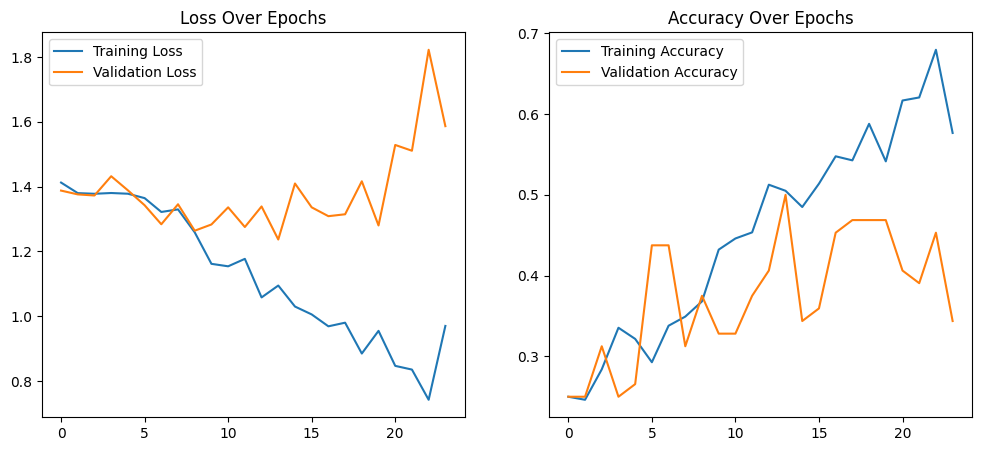


Final Training Loss: 0.9699
Final Validation Loss: 1.5865
Final Training Accuracy: 0.5766
Final Validation Accuracy: 0.3438
4/4 [==============================] - 0s 37ms/step - loss: 1.1394 - accuracy: 0.5243
Test Loss: 1.1394124031066895, Test Accuracy: 0.5242718458175659


In [37]:
epochs = 100

# Create and evaluate the model with early stopping
results_df, model_early_stop_10 = full_model_evaluation(
    create_model_func=lambda: build_basic_model((256, 256, 3), 20, 4),
    config_description="Model with Early Stopping (patience 10)",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df,
    callbacks=[early_stopping]
)

In [38]:
results_df

,Configuration,Final Train Loss,Final Validation Loss,Final Train Accuracy,Final Validation Accuracy,Test Loss,Test Accuracy,Total Training Time (s),Average Time per Epoch (s)
0,Baseline Model,0.000719,3.298196,1.000000,0.609375,3.754167,0.466019,133.340943,1.333409
1,Model with L1 Regularization (0.001),4.019690,4.199212,0.232412,0.250000,4.199183,0.242718,157.656868,1.576569
2,Model with L1 Regularization (0.01),28.146200,30.211891,0.201005,0.281250,30.211897,0.252427,150.499986,1.505000
3,Model with L2 Regularization (0.001),3.991182,4.155935,0.238693,0.281250,4.156052,0.252427,148.454952,1.484550
4,Model with L2 Regularization (0.01),28.139238,30.197332,0.218593,0.203125,30.197268,0.252427,148.498567,1.484986
5,Model with batch normalization,0.511984,1.664261,0.802764,0.515625,1.785823,0.495146,196.073616,1.960736
6,Model with dropout (0.5),1.387294,1.386011,0.250000,0.281250,1.386278,0.252427,205.491993,2.054920
7,Model with dropout (0.35),1.387076,1.385794,0.256281,0.281250,1.386235,0.252427,205.778939,2.057789
8,Model with dropout (0.2),1.101971,1.289256,0.459799,0.343750,1.320711,0.320388,204.991889,2.049919
9,Model with Early Stopping (patience 10),0.969935,1.586537,0.576633,0.343750,1.139412,0.524272,39.110418,1.629601


#### Data Augmentation


In [39]:
def build_model_with_augmentation(input_shape, num_layers, num_classes):
    """
    Builds a Sequential model with data augmentation layers for random flipping and rotation.

    Args:
        input_shape (tuple): Shape of the input data (excluding batch size).
        num_layers (int): Number of Dense layers in the model.
        num_classes (int): Number of output classes.

    Returns:
        keras.models.Model: Compiled Keras model with data augmentation.
    """
    model = keras.models.Sequential([
        # Data augmentation layers
        keras.layers.InputLayer(input_shape=input_shape),
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=42),
        keras.layers.experimental.preprocessing.RandomRotation(0.2, seed=42),

        # Flattening the input for the Dense layers
        keras.layers.Flatten()
    ])

    # Add the Dense layers
    for _ in range(num_layers):
        model.add(keras.layers.Dense(100, activation='relu', kernel_initializer=weight_initializer))
    model.add(keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=weight_initializer))

    return model


Epoch 1/100
25/25 [==============================] - 8s 62ms/step - loss: 1.4174 - accuracy: 0.2237 - val_loss: 1.3871 - val_accuracy: 0.2656
Epoch 2/100
25/25 [==============================] - 1s 49ms/step - loss: 1.3849 - accuracy: 0.2525 - val_loss: 1.3796 - val_accuracy: 0.3750
Epoch 3/100
25/25 [==============================] - 1s 53ms/step - loss: 1.3798 - accuracy: 0.2990 - val_loss: 1.3919 - val_accuracy: 0.2500
Epoch 4/100
25/25 [==============================] - 2s 79ms/step - loss: 1.3719 - accuracy: 0.3229 - val_loss: 1.3699 - val_accuracy: 0.2969
Epoch 5/100
25/25 [==============================] - 2s 85ms/step - loss: 1.3710 - accuracy: 0.2889 - val_loss: 1.3734 - val_accuracy: 0.2656
Epoch 6/100
25/25 [==============================] - 1s 51ms/step - loss: 1.3520 - accuracy: 0.3103 - val_loss: 1.3502 - val_accuracy: 0.3594
Epoch 7/100
25/25 [==============================] - 1s 53ms/step - loss: 1.3453 - accuracy: 0.3405 - val_loss: 1.3526 - val_accuracy: 0.3750
Epoch 

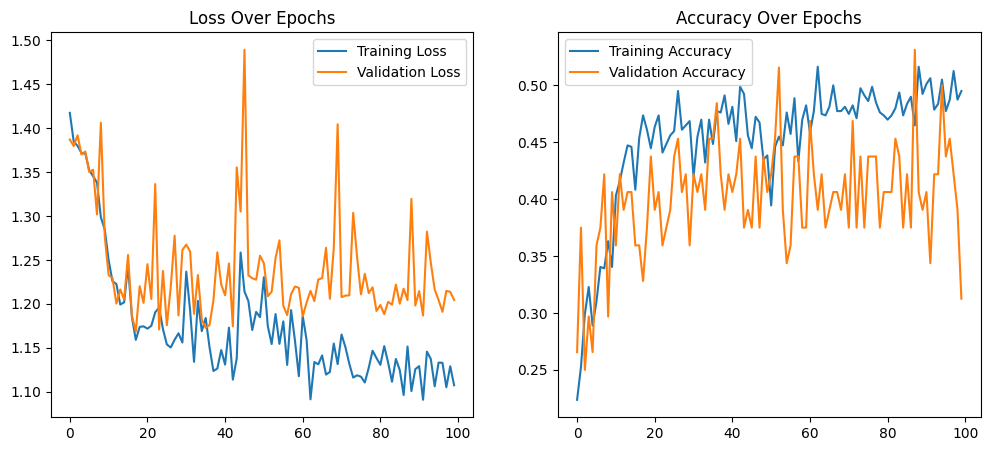


Final Training Loss: 1.1075
Final Validation Loss: 1.2045
Final Training Accuracy: 0.4950
Final Validation Accuracy: 0.3125
4/4 [==============================] - 0s 30ms/step - loss: 1.1189 - accuracy: 0.5340
Test Loss: 1.118910551071167, Test Accuracy: 0.5339806079864502


In [40]:
epochs = 100

# Create and evaluate the model with early stopping
results_df, model_augmentation_1 = full_model_evaluation(
    create_model_func=lambda: build_model_with_augmentation((256, 256, 3), 20, 4),
    config_description="Model with Augmentation (Flip, Rotation)",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df
)

In [41]:
results_df

,Configuration,Final Train Loss,Final Validation Loss,Final Train Accuracy,Final Validation Accuracy,Test Loss,Test Accuracy,Total Training Time (s),Average Time per Epoch (s)
0,Baseline Model,0.000719,3.298196,1.000000,0.609375,3.754167,0.466019,133.340943,1.333409
1,Model with L1 Regularization (0.001),4.019690,4.199212,0.232412,0.250000,4.199183,0.242718,157.656868,1.576569
2,Model with L1 Regularization (0.01),28.146200,30.211891,0.201005,0.281250,30.211897,0.252427,150.499986,1.505000
3,Model with L2 Regularization (0.001),3.991182,4.155935,0.238693,0.281250,4.156052,0.252427,148.454952,1.484550
4,Model with L2 Regularization (0.01),28.139238,30.197332,0.218593,0.203125,30.197268,0.252427,148.498567,1.484986
5,Model with batch normalization,0.511984,1.664261,0.802764,0.515625,1.785823,0.495146,196.073616,1.960736
6,Model with dropout (0.5),1.387294,1.386011,0.250000,0.281250,1.386278,0.252427,205.491993,2.054920
7,Model with dropout (0.35),1.387076,1.385794,0.256281,0.281250,1.386235,0.252427,205.778939,2.057789
8,Model with dropout (0.2),1.101971,1.289256,0.459799,0.343750,1.320711,0.320388,204.991889,2.049919
9,Model with Early Stopping (patience 10),0.969935,1.586537,0.576633,0.343750,1.139412,0.524272,39.110418,1.629601


#### Batch Norm + Early Stop + Augmentation

In [42]:
def build_augmented_bn_model(input_shape, num_layers, num_classes):
    """
    Builds a Sequential model with data augmentation, batch normalization, and dropout.

    Args:
        input_shape (tuple): Shape of the input data (excluding batch size).
        num_layers (int): Number of Dense layers in the model.
        num_classes (int): Number of output classes.

    Returns:
        keras.models.Model: Compiled Keras model with data augmentation and batch normalization.
    """
    model = keras.models.Sequential([
        # Data augmentation layers
        keras.layers.InputLayer(input_shape=input_shape),
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=42),
        keras.layers.experimental.preprocessing.RandomRotation(0.2, seed=42),

        # Flattening the input for the Dense layers
        keras.layers.Flatten()
    ])

    # Adding dense layers with Batch Normalization
    for _ in range(num_layers):
        model.add(keras.layers.Dense(100, activation='relu', kernel_initializer=weight_initializer))
        model.add(keras.layers.BatchNormalization())

    # Output layer
    model.add(keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=weight_initializer))

    return model

Epoch 1/100
25/25 [==============================] - 17s 119ms/step - loss: 1.9145 - accuracy: 0.2512 - val_loss: 1.3838 - val_accuracy: 0.2812
Epoch 2/100
25/25 [==============================] - 2s 95ms/step - loss: 1.7276 - accuracy: 0.2663 - val_loss: 1.3850 - val_accuracy: 0.2344
Epoch 3/100
25/25 [==============================] - 2s 69ms/step - loss: 1.6053 - accuracy: 0.2814 - val_loss: 1.3877 - val_accuracy: 0.2500
Epoch 4/100
25/25 [==============================] - 2s 67ms/step - loss: 1.5644 - accuracy: 0.2864 - val_loss: 1.4150 - val_accuracy: 0.2500
Epoch 5/100
25/25 [==============================] - 2s 69ms/step - loss: 1.5446 - accuracy: 0.2588 - val_loss: 1.5570 - val_accuracy: 0.2031
Epoch 6/100
25/25 [==============================] - 2s 69ms/step - loss: 1.5017 - accuracy: 0.2764 - val_loss: 1.6977 - val_accuracy: 0.2031
Epoch 7/100
25/25 [==============================] - 2s 68ms/step - loss: 1.5044 - accuracy: 0.2575 - val_loss: 1.6872 - val_accuracy: 0.2500
Epoc

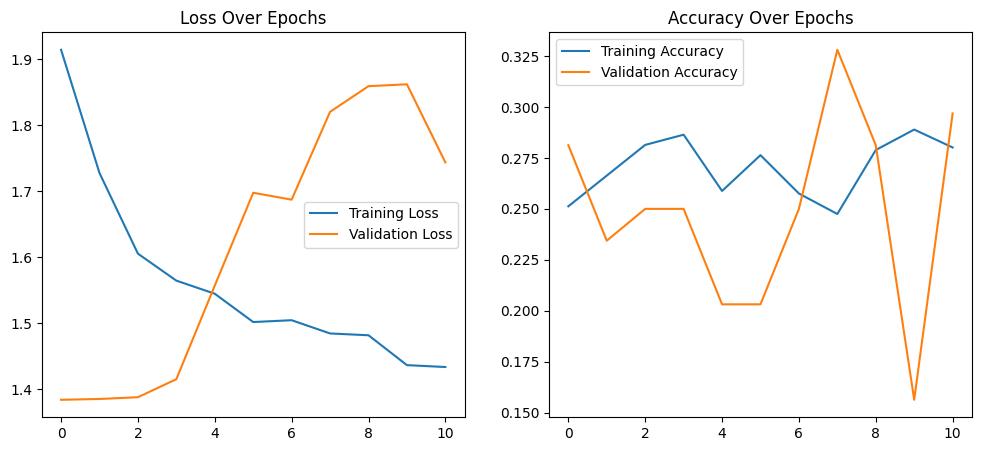


Final Training Loss: 1.4335
Final Validation Loss: 1.7437
Final Training Accuracy: 0.2802
Final Validation Accuracy: 0.2969
4/4 [==============================] - 0s 29ms/step - loss: 1.3903 - accuracy: 0.2427
Test Loss: 1.390307068824768, Test Accuracy: 0.24271844327449799


In [43]:
epochs = 100

results_df, model_mix_1 = full_model_evaluation(
    create_model_func=lambda: build_augmented_bn_model((256, 256, 3), 20, 4),
    config_description="Augmentation + Batch Norm + Early Stop",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df,
    callbacks=[early_stopping]
)

In [44]:
results_df

,Configuration,Final Train Loss,Final Validation Loss,Final Train Accuracy,Final Validation Accuracy,Test Loss,Test Accuracy,Total Training Time (s),Average Time per Epoch (s)
0,Baseline Model,0.000719,3.298196,1.000000,0.609375,3.754167,0.466019,133.340943,1.333409
1,Model with L1 Regularization (0.001),4.019690,4.199212,0.232412,0.250000,4.199183,0.242718,157.656868,1.576569
2,Model with L1 Regularization (0.01),28.146200,30.211891,0.201005,0.281250,30.211897,0.252427,150.499986,1.505000
3,Model with L2 Regularization (0.001),3.991182,4.155935,0.238693,0.281250,4.156052,0.252427,148.454952,1.484550
4,Model with L2 Regularization (0.01),28.139238,30.197332,0.218593,0.203125,30.197268,0.252427,148.498567,1.484986
5,Model with batch normalization,0.511984,1.664261,0.802764,0.515625,1.785823,0.495146,196.073616,1.960736
6,Model with dropout (0.5),1.387294,1.386011,0.250000,0.281250,1.386278,0.252427,205.491993,2.054920
7,Model with dropout (0.35),1.387076,1.385794,0.256281,0.281250,1.386235,0.252427,205.778939,2.057789
8,Model with dropout (0.2),1.101971,1.289256,0.459799,0.343750,1.320711,0.320388,204.991889,2.049919
9,Model with Early Stopping (patience 10),0.969935,1.586537,0.576633,0.343750,1.139412,0.524272,39.110418,1.629601


#### Augmentation + L1 Norm + Early Stop

In [45]:
def build_augmented_l1_model(input_shape, num_layers, num_classes, l1_factor=0.001):
    """
    Builds a Sequential model with data augmentation and L1 regularization.

    Args:
        input_shape (tuple): Shape of the input data (excluding batch size).
        num_layers (int): Number of Dense layers in the model.
        num_classes (int): Number of output classes.
        l1_factor (float): Coefficient for L1 regularization.

    Returns:
        keras.models.Model: Compiled Keras model with data augmentation and L1 regularization.
    """
    model = keras.models.Sequential([
        # Input and data augmentation layers
        keras.layers.InputLayer(input_shape=input_shape),
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=42),
        keras.layers.experimental.preprocessing.RandomRotation(0.2, seed=42),

        # Flattening the input for the Dense layers
        keras.layers.Flatten(),
    ])

    # Adding dense layers with L1 regularization
    for _ in range(num_layers):
        model.add(keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l1(l1_factor), kernel_initializer=weight_initializer))

    # Output layer
    model.add(keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=weight_initializer))

    return model

Epoch 1/100
25/25 [==============================] - 9s 80ms/step - loss: 28.6141 - accuracy: 0.2412 - val_loss: 17.9661 - val_accuracy: 0.2031
Epoch 2/100
25/25 [==============================] - 1s 59ms/step - loss: 14.9979 - accuracy: 0.2136 - val_loss: 12.6041 - val_accuracy: 0.2500
Epoch 3/100
25/25 [==============================] - 1s 59ms/step - loss: 10.8908 - accuracy: 0.2286 - val_loss: 9.4467 - val_accuracy: 0.2812
Epoch 4/100
25/25 [==============================] - 1s 58ms/step - loss: 8.1275 - accuracy: 0.2487 - val_loss: 7.0393 - val_accuracy: 0.2656
Epoch 5/100
25/25 [==============================] - 1s 60ms/step - loss: 6.0980 - accuracy: 0.2312 - val_loss: 5.4219 - val_accuracy: 0.2812
Epoch 6/100
25/25 [==============================] - 1s 59ms/step - loss: 4.7913 - accuracy: 0.2337 - val_loss: 4.3764 - val_accuracy: 0.2656
Epoch 7/100
25/25 [==============================] - 2s 82ms/step - loss: 4.1349 - accuracy: 0.2274 - val_loss: 4.1696 - val_accuracy: 0.2031
E

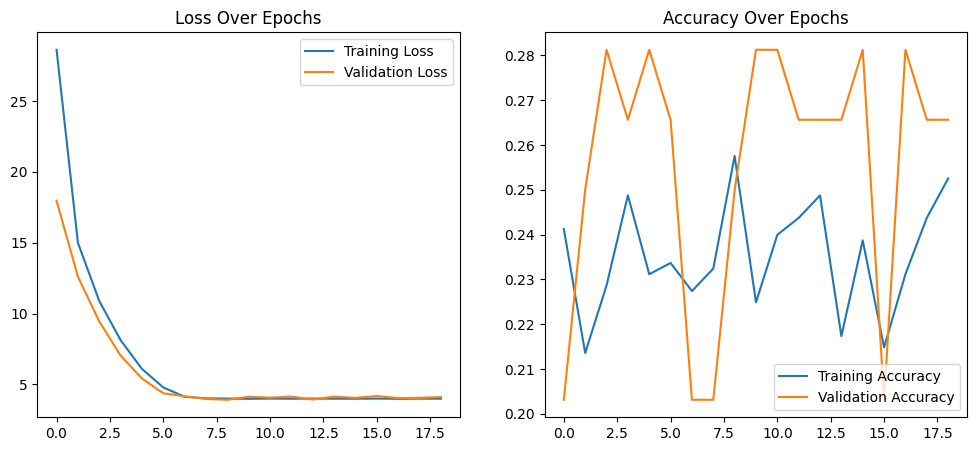


Final Training Loss: 3.9968
Final Validation Loss: 4.1145
Final Training Accuracy: 0.2525
Final Validation Accuracy: 0.2656
4/4 [==============================] - 0s 33ms/step - loss: 3.9213 - accuracy: 0.2427
Test Loss: 3.9213333129882812, Test Accuracy: 0.24271844327449799


In [46]:
epochs=100

results_df, model_mix_2 = full_model_evaluation(
    create_model_func=lambda: build_augmented_l1_model((256, 256, 3), 20, 4),
    config_description="Augmentation + L1 Norm (0.001) + Early Stop",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df,
    callbacks=[early_stopping]
)

In [47]:
results_df

,Configuration,Final Train Loss,Final Validation Loss,Final Train Accuracy,Final Validation Accuracy,Test Loss,Test Accuracy,Total Training Time (s),Average Time per Epoch (s)
0,Baseline Model,0.000719,3.298196,1.000000,0.609375,3.754167,0.466019,133.340943,1.333409
1,Model with L1 Regularization (0.001),4.019690,4.199212,0.232412,0.250000,4.199183,0.242718,157.656868,1.576569
2,Model with L1 Regularization (0.01),28.146200,30.211891,0.201005,0.281250,30.211897,0.252427,150.499986,1.505000
3,Model with L2 Regularization (0.001),3.991182,4.155935,0.238693,0.281250,4.156052,0.252427,148.454952,1.484550
4,Model with L2 Regularization (0.01),28.139238,30.197332,0.218593,0.203125,30.197268,0.252427,148.498567,1.484986
5,Model with batch normalization,0.511984,1.664261,0.802764,0.515625,1.785823,0.495146,196.073616,1.960736
6,Model with dropout (0.5),1.387294,1.386011,0.250000,0.281250,1.386278,0.252427,205.491993,2.054920
7,Model with dropout (0.35),1.387076,1.385794,0.256281,0.281250,1.386235,0.252427,205.778939,2.057789
8,Model with dropout (0.2),1.101971,1.289256,0.459799,0.343750,1.320711,0.320388,204.991889,2.049919
9,Model with Early Stopping (patience 10),0.969935,1.586537,0.576633,0.343750,1.139412,0.524272,39.110418,1.629601


#### Augmentation + Early Stopping

Epoch 1/100
25/25 [==============================] - 8s 73ms/step - loss: 1.3935 - accuracy: 0.2188 - val_loss: 1.3861 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 1s 54ms/step - loss: 1.3843 - accuracy: 0.2399 - val_loss: 1.3837 - val_accuracy: 0.2969
Epoch 3/100
25/25 [==============================] - 1s 50ms/step - loss: 1.3770 - accuracy: 0.2864 - val_loss: 1.3885 - val_accuracy: 0.2500
Epoch 4/100
25/25 [==============================] - 1s 59ms/step - loss: 1.3743 - accuracy: 0.3191 - val_loss: 1.3700 - val_accuracy: 0.3594
Epoch 5/100
25/25 [==============================] - 2s 80ms/step - loss: 1.3727 - accuracy: 0.2802 - val_loss: 1.3777 - val_accuracy: 0.3281
Epoch 6/100
25/25 [==============================] - 2s 79ms/step - loss: 1.3703 - accuracy: 0.2940 - val_loss: 1.3572 - val_accuracy: 0.2969
Epoch 7/100
25/25 [==============================] - 1s 54ms/step - loss: 1.3333 - accuracy: 0.3568 - val_loss: 1.3427 - val_accuracy: 0.3438
Epoch 

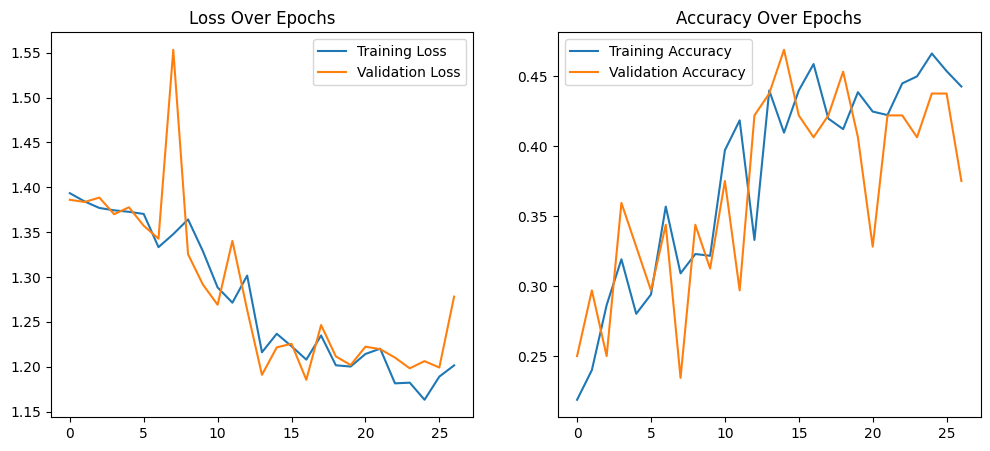


Final Training Loss: 1.2015
Final Validation Loss: 1.2782
Final Training Accuracy: 0.4425
Final Validation Accuracy: 0.3750
4/4 [==============================] - 0s 27ms/step - loss: 1.1664 - accuracy: 0.5340
Test Loss: 1.166407585144043, Test Accuracy: 0.5339806079864502


In [48]:
epochs = 100

# Create and evaluate the model with early stopping
results_df, model_augmentation_2 = full_model_evaluation(
    create_model_func=lambda: build_model_with_augmentation((256, 256, 3), 20, 4),
    config_description="Model with Augmentation (Flip, Rotation) + Early Stop",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df,
    callbacks=[early_stopping]
)

In [49]:
results_df

,Configuration,Final Train Loss,Final Validation Loss,Final Train Accuracy,Final Validation Accuracy,Test Loss,Test Accuracy,Total Training Time (s),Average Time per Epoch (s)
0,Baseline Model,0.000719,3.298196,1.000000,0.609375,3.754167,0.466019,133.340943,1.333409
1,Model with L1 Regularization (0.001),4.019690,4.199212,0.232412,0.250000,4.199183,0.242718,157.656868,1.576569
2,Model with L1 Regularization (0.01),28.146200,30.211891,0.201005,0.281250,30.211897,0.252427,150.499986,1.505000
3,Model with L2 Regularization (0.001),3.991182,4.155935,0.238693,0.281250,4.156052,0.252427,148.454952,1.484550
4,Model with L2 Regularization (0.01),28.139238,30.197332,0.218593,0.203125,30.197268,0.252427,148.498567,1.484986
5,Model with batch normalization,0.511984,1.664261,0.802764,0.515625,1.785823,0.495146,196.073616,1.960736
6,Model with dropout (0.5),1.387294,1.386011,0.250000,0.281250,1.386278,0.252427,205.491993,2.054920
7,Model with dropout (0.35),1.387076,1.385794,0.256281,0.281250,1.386235,0.252427,205.778939,2.057789
8,Model with dropout (0.2),1.101971,1.289256,0.459799,0.343750,1.320711,0.320388,204.991889,2.049919
9,Model with Early Stopping (patience 10),0.969935,1.586537,0.576633,0.343750,1.139412,0.524272,39.110418,1.629601


#### Ablation Study Results
The ablation study considered the following techniques for improving model performance:
1. L1 and L2 regularisation with two variants of regularisation coefficients: 0.01 and 0.001 (trained on 100 epochs)
2. Batch Normalisation (trained on 100 epochs)
3. Dropout applied to all layers on three ranges of dropout rate (0.5, 0.35, 0.2)
4. Early Stopping applied on validation loss (patience 10)
5. Training data augmentation with random flip and random rotation
6. Mix of training data augmentation, Batch Normalisation and Early stopping (patience 10)
7. Mix of training data augmentation, L1 normalisation (alpha 0.001) and Early stopping (patience 10)
8. Mix of model Augmentation and Early stopping (patience 10)

The models were compared based on Test accuracy, calculated on isolated test dataset (10% of all data)

**Results:**

The goal of improving the test accuracy by 10% compared to baseline model was achieved by:
1. model with batch normalisation applied to all dense layers - this technique allowed to achieve better results because it helps in stabilizing and accelerating the training process. Batch normalization achieves this by normalizing the inputs to each layer, which reduces internal covariate shift and allows for higher learning rates without the risk of divergence. Additionally, it imparts a slight regularization effect, which can improve the model's generalization on unseen test data, often resulting in better performance compared to models without batch normalization.
2. model with training data augmentation - this technique effectively increases the diversity of the training data, which helps the model generalize better to new, unseen data. This process simulates a variety of scenarios that the model might face in real-world applications, thus reducing overfitting by preventing the model from learning noise and specific patterns in the training dataset. Consequently, the model trained with augmented data can perform better on the test dataset, as it has learned to be robust to variations in input data, leading to improved overall performance.
3. Model with training data augmentation and early stopping - introducing early stopping with a patience of 10 allows the model to halt training at an optimal point before it starts to learn noise and specific, non-generalizable patterns from the training data. Coupled with data augmentation, which already enhances model robustness by presenting varied data scenarios during training, early stopping ensures the model retains high generalizability and performs even better on unseen test data.

**Conclusion:**

If case when modeling would stop at this point, it would be best to implement the model with training data augmentation and early stopping as thanks to augmentation the model generalises better than highly overfitting baseline model. Even if the test accuracy of this model is slightly worse than other models mentioned in the results section above, from the training graphs, we can conclude that early stopping during training might lead to better generalisation and less overfitting to training data.

### Question 1.3 Convolutional Neural Network (25 points)

Now, let's define the Convolutional Neural Network.

❓ **Question** ❓ Define a CNN that is composed of:
- a Conv2D layer with 32 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (2, 2)
- a Conv2D layer with 64 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (2, 2)
- a Conv2D layer with 128 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (3, 3)
- a Flatten layer
- a dense function with 120 neurons with the `relu` activation function
- a dense function with 60 neurons with the `relu` activation function
- a dropout layer (with a rate of 0.5), to regularize the network
- a dense function related to your task

Estimate the model and report your test accuracy. Is it better than the multi-layer perceptron.

In [50]:
def build_cnn_model(input_shape, num_classes):
    model = keras.models.Sequential([
        # First Convolutional Block
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((3, 3)),

        # Flattening the outputs of the last pooling layer to feed it to the dense layers
        keras.layers.Flatten(),

        # Dense Layers
        keras.layers.Dense(120, activation='relu'),
        keras.layers.Dense(60, activation='relu'),

        # Dropout Layer
        keras.layers.Dropout(0.5),

        # Output Layer
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

Epoch 1/100
25/25 [==============================] - 10s 104ms/step - loss: 1.4000 - accuracy: 0.3500 - val_loss: 1.1983 - val_accuracy: 0.4531
Epoch 2/100
25/25 [==============================] - 5s 84ms/step - loss: 1.1803 - accuracy: 0.4786 - val_loss: 1.1335 - val_accuracy: 0.4375
Epoch 3/100
25/25 [==============================] - 2s 83ms/step - loss: 1.0167 - accuracy: 0.5352 - val_loss: 0.9787 - val_accuracy: 0.5781
Epoch 4/100
25/25 [==============================] - 2s 80ms/step - loss: 0.9234 - accuracy: 0.6332 - val_loss: 0.9169 - val_accuracy: 0.5625
Epoch 5/100
25/25 [==============================] - 2s 97ms/step - loss: 0.7958 - accuracy: 0.6947 - val_loss: 1.1274 - val_accuracy: 0.5312
Epoch 6/100
25/25 [==============================] - 2s 98ms/step - loss: 0.6481 - accuracy: 0.7349 - val_loss: 0.9610 - val_accuracy: 0.7031
Epoch 7/100
25/25 [==============================] - 2s 82ms/step - loss: 0.4338 - accuracy: 0.8543 - val_loss: 1.0024 - val_accuracy: 0.6094
Epoc

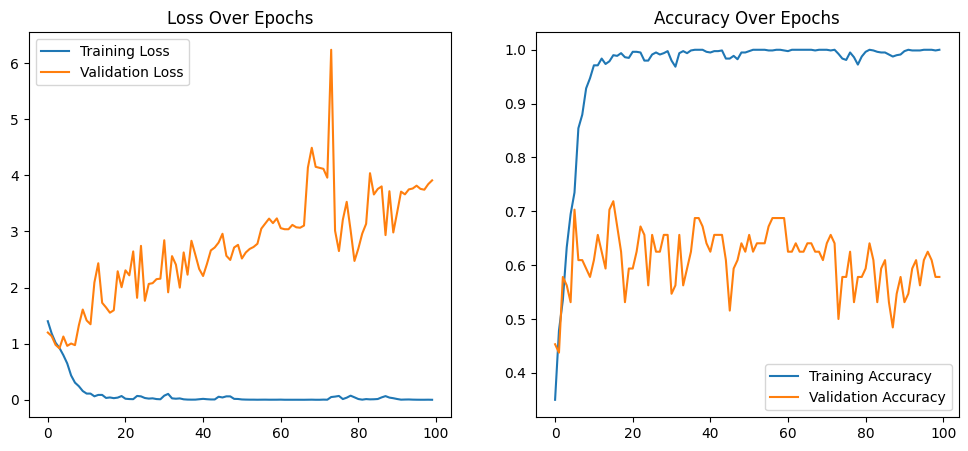


Final Training Loss: 0.0001
Final Validation Loss: 3.9098
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.5781
4/4 [==============================] - 1s 153ms/step - loss: 6.0904 - accuracy: 0.5340
Test Loss: 6.090440273284912, Test Accuracy: 0.5339806079864502


In [51]:
input_shape = (256, 256, 3)
num_classes = 4

epochs = 100

results_df, model_cnn_1 = full_model_evaluation(
    create_model_func=lambda: build_cnn_model(input_shape, num_classes),
    config_description="CNN 1",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df
)

#### CNN + Augmentation + Early Stopping

In [52]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [53]:
def build_cnn_with_augmentation(input_shape, num_classes):
    model = keras.models.Sequential([
        # Data Augmentation layers
        keras.layers.InputLayer(input_shape=input_shape),
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=42),
        keras.layers.experimental.preprocessing.RandomRotation(0.2, seed=42),

        # First Convolutional Block
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((3, 3)),

        # Flattening and Dense Layers
        keras.layers.Flatten(),
        keras.layers.Dense(120, activation='relu'),
        keras.layers.Dense(60, activation='relu'),
        keras.layers.Dropout(0.5),

        # Output Layer
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

Epoch 1/100
25/25 [==============================] - 4s 94ms/step - loss: 1.4379 - accuracy: 0.2562 - val_loss: 1.3834 - val_accuracy: 0.2031
Epoch 2/100
25/25 [==============================] - 2s 87ms/step - loss: 1.3602 - accuracy: 0.3191 - val_loss: 1.3041 - val_accuracy: 0.3750
Epoch 3/100
25/25 [==============================] - 3s 109ms/step - loss: 1.2755 - accuracy: 0.4045 - val_loss: 1.2379 - val_accuracy: 0.3906
Epoch 4/100
25/25 [==============================] - 2s 95ms/step - loss: 1.2423 - accuracy: 0.4384 - val_loss: 1.2157 - val_accuracy: 0.5000
Epoch 5/100
25/25 [==============================] - 2s 87ms/step - loss: 1.1887 - accuracy: 0.4435 - val_loss: 1.1308 - val_accuracy: 0.4531
Epoch 6/100
25/25 [==============================] - 2s 86ms/step - loss: 1.1658 - accuracy: 0.4774 - val_loss: 1.1702 - val_accuracy: 0.5469
Epoch 7/100
25/25 [==============================] - 2s 85ms/step - loss: 1.1319 - accuracy: 0.5327 - val_loss: 1.0920 - val_accuracy: 0.6094
Epoch

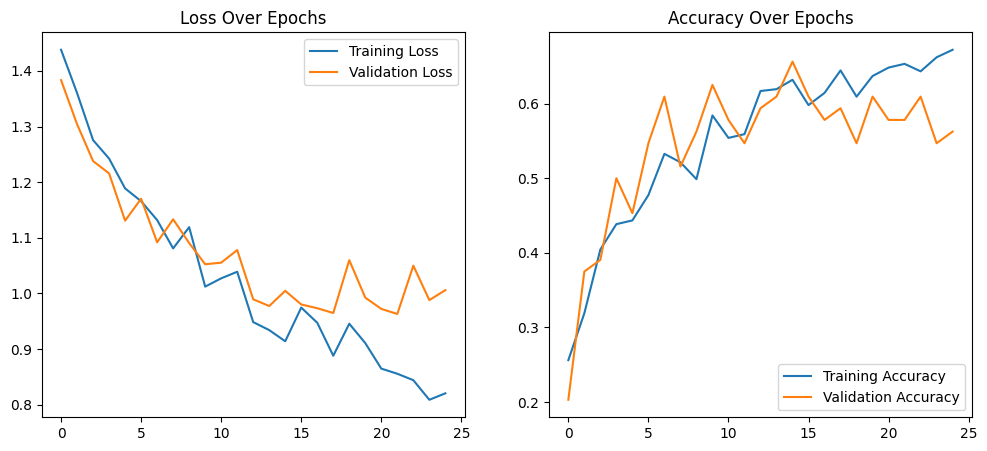


Final Training Loss: 0.8205
Final Validation Loss: 1.0060
Final Training Accuracy: 0.6721
Final Validation Accuracy: 0.5625
4/4 [==============================] - 0s 32ms/step - loss: 0.9071 - accuracy: 0.6408
Test Loss: 0.9071406126022339, Test Accuracy: 0.6407766938209534


In [54]:
input_shape = (256, 256, 3)
num_classes = 4

epochs = 100

results_df, model_cnn_2 = full_model_evaluation(
    create_model_func=lambda: build_cnn_with_augmentation(input_shape, num_classes),
    config_description="CNN + Augmentation + Early Stop",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df,
    callbacks=[early_stopping]
)

In [55]:
results_df

,Configuration,Final Train Loss,Final Validation Loss,Final Train Accuracy,Final Validation Accuracy,Test Loss,Test Accuracy,Total Training Time (s),Average Time per Epoch (s)
0,Baseline Model,0.000719,3.298196,1.000000,0.609375,3.754167,0.466019,133.340943,1.333409
1,Model with L1 Regularization (0.001),4.019690,4.199212,0.232412,0.250000,4.199183,0.242718,157.656868,1.576569
2,Model with L1 Regularization (0.01),28.146200,30.211891,0.201005,0.281250,30.211897,0.252427,150.499986,1.505000
3,Model with L2 Regularization (0.001),3.991182,4.155935,0.238693,0.281250,4.156052,0.252427,148.454952,1.484550
4,Model with L2 Regularization (0.01),28.139238,30.197332,0.218593,0.203125,30.197268,0.252427,148.498567,1.484986
5,Model with batch normalization,0.511984,1.664261,0.802764,0.515625,1.785823,0.495146,196.073616,1.960736
6,Model with dropout (0.5),1.387294,1.386011,0.250000,0.281250,1.386278,0.252427,205.491993,2.054920
7,Model with dropout (0.35),1.387076,1.385794,0.256281,0.281250,1.386235,0.252427,205.778939,2.057789
8,Model with dropout (0.2),1.101971,1.289256,0.459799,0.343750,1.320711,0.320388,204.991889,2.049919
9,Model with Early Stopping (patience 10),0.969935,1.586537,0.576633,0.343750,1.139412,0.524272,39.110418,1.629601


#### CNN Modeling Results

Two CNN models were applied:
1. Simple CNN described in the task
2. The same CNN, but combined with **Training Data Augmentation** and **Early Stopping with patience 10**

**Results**

- The first model achieves similar performance to the best DNN model, and highly overfitts the training data (based on the training loss and accuracy graphs, and training accuracy equal to 100%).

- The second model, definitely outperforms all previous architectures achieving test accuracy of 64%. This is the effect of additional performance increasing techniques, which prevent model from overfitting to the training dataset, causing it to perform better on unseen data.

**Conclusion**

If this would be the last step of the modeling, I would suggest implementing the Second model (CNN + Augmentation + Early Stop) as it achieves satisfactory results. However, the outputs of such model, when implemented into the product, should still be interpreted with a grain of salt, as the level of test accuracy, is not decent enough to assume that the model makes correct decisions in real-life application.

### Question 1.4 Transfer learning (35 points)

In this question, we will use the several well-known architectures that has been trained on ImageNet which is a very large database of images of different categories. In a nutshell, these architectures have already learnt kernels which are supposed to be good not only for the task it has been train on but maybe for other tasks.

The idea is that first layers are not specialized for the particular task it has been trained on; only the last ones are. Therefore, we will load the existing network, remove the last fully connected layers, replace them by new connected layers (whose weights are randomly set), and train these last layers on a specific classification task - here, separate types of flower. The underlying idea is that the first convolutional layers of model, that has already been trained, corresponds to filters that are able to extract meaning features from images. And you will only learn the last layers for your particular problem.

❓ **Question** ❓ Write a first function `load_model()` that loads the pretrained models from `tensorflow.keras.applications`. Especially, look at the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications) to load the model where:
- the `weights` have been learnt on `imagenet`
- the `input_shape` corresponds to the input shape of any of your images - you have to resize them in case they are not of the same size
- the `include_top` argument is set to `False` in order not to load the fully-connected layers of the VGG-16 without the last layer which was specifically trained on `imagenet`

Write a function that takes the previous model as input the set the girst layers to be non-trainable, by applying `model.trainable = False`. Then check-out the summary of the model to see that now, the parameters are `non-trainable`. Then write a function that adds flattening and dense layers after the first convolutional layers. You can define each layer (or group of layers) separately and concatenate them using the classic `layers.Sequential()` like below:

```
model = tf.keras.Sequential([
  base_model,
  flattening_layer,
  dense_layer,
  prediction_layer
])
```

Replicate the above steps by adding a flattening and two dense layers (the first with 500 neurons) to the previous model.

Estimate the model and report the accuracy and loss achieved. Explain whether model would benefit from transfer lerarning in comparison to the previous model architectures.

Try to use the following models: VGG16, Inception, ResNet, MobileNet and EfficientNet and compare their performance and running time. Explain which model would work the best.

In [56]:
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet_v2, efficientnet


def load_model_with_preprocessing(model_name, input_shape=(256, 256, 3)):
    """
    Loads a specified pre-trained model with ImageNet weights and its preprocessing function.

    Args:
        model_name (str): Name of the model to load (e.g., 'VGG16', 'InceptionV3').
        input_shape (tuple): Shape of the input images.

    Returns:
        model (tf.keras.Model): The pre-trained model with top layers removed.
        preprocess_input (function): Corresponding preprocessing function for the model.
    """
    models = {
        'VGG16': (vgg16.VGG16, vgg16.preprocess_input),
        'InceptionV3': (inception_v3.InceptionV3, inception_v3.preprocess_input),
        'ResNet50': (resnet50.ResNet50, resnet50.preprocess_input),
        'MobileNetV2': (mobilenet_v2.MobileNetV2, mobilenet_v2.preprocess_input),
        'EfficientNetB0': (efficientnet.EfficientNetB0, efficientnet.preprocess_input)
    }

    if model_name not in models:
        raise ValueError(f"Unsupported model name. Please choose from {list(models.keys())}")

    model_class, preprocess_input = models[model_name]
    model = model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    return model, preprocess_input


def prepare_and_summarize_base_model(base_model):
    """
    Sets the base model layers as non-trainable and prints the model summary.

    Args:
        base_model (tf.keras.Model): The pre-trained base model with top layers removed.
    """
    base_model.trainable = False
    print("Base Model Summary:")
    base_model.summary()
    return base_model


def assemble_complete_model(base_model, preprocess_input, input_shape, num_classes):
    """
    Assembles the complete transfer learning model with augmentation, preprocessing, and classification layers.

    Args:
        base_model (tf.keras.Model): The pre-trained base model, set as non-trainable.
        preprocess_input (function): Preprocessing function for the base model.
        input_shape (tuple): The input shape for the model.
        num_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: The assembled model.
    """
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ], name='data_augmentation')

    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        data_augmentation,
        tf.keras.layers.Lambda(preprocess_input, name='preprocessing'),
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(500, activation='relu', kernel_initializer=weight_initializer),
        tf.keras.layers.Dropout(0.5, seed=42),
        tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=weight_initializer)
    ])

    return model


def create_pretrained_model_with_augmentation(model_name, input_shape, num_classes):
    """
    Creates a transfer learning model with data augmentation using a specified pre-trained model.

    Args:
        model_name (str): Name of the pre-trained model to use.
        input_shape (tuple): Expected input shape for the model.
        num_classes (int): Number of classes for the output layer.

    Returns:
        tf.keras.Model: Assembled and compiled model ready for training.
    """
    # Load the base model and its preprocessing function
    base_model, preprocess_input = load_model_with_preprocessing(model_name, input_shape)

    # Prepare the base model and print its summary
    base_model = prepare_and_summarize_base_model(base_model)

    # Assemble the full model with augmentation and classification layers
    model = assemble_complete_model(base_model, preprocess_input, input_shape, num_classes)

    return model

58889256/58889256 [==============================] - 0s 0us/step
Base Model Summary:
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                          

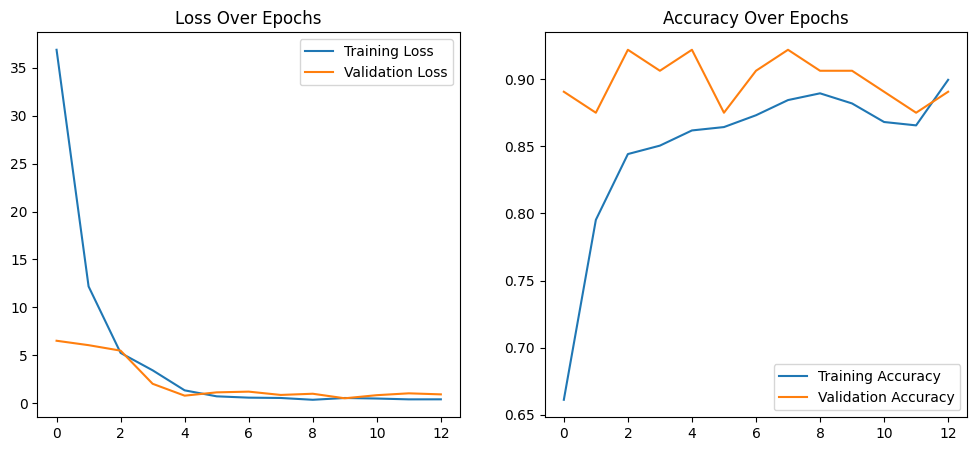


Final Training Loss: 0.3913
Final Validation Loss: 0.9085
Final Training Accuracy: 0.8995
Final Validation Accuracy: 0.8906
4/4 [==============================] - 3s 929ms/step - loss: 1.3666 - accuracy: 0.9126
Test Loss: 1.3665742874145508, Test Accuracy: 0.9126213788986206


In [57]:
epochs = 100

results_df, model_vgg_16_1 = full_model_evaluation(
    create_model_func=lambda: create_pretrained_model_with_augmentation('VGG16', input_shape=(256, 256, 3), num_classes=4),
    config_description="VGG_16_trial",
    train_dataset=train_dataset_nopreproc,
    val_dataset=val_dataset_nopreproc,
    test_dataset=test_dataset_nopreproc,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df,
    callbacks=[early_stopping]
)

94765736/94765736 [==============================] - 1s 0us/step
Base Model Summary:
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_18[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)  

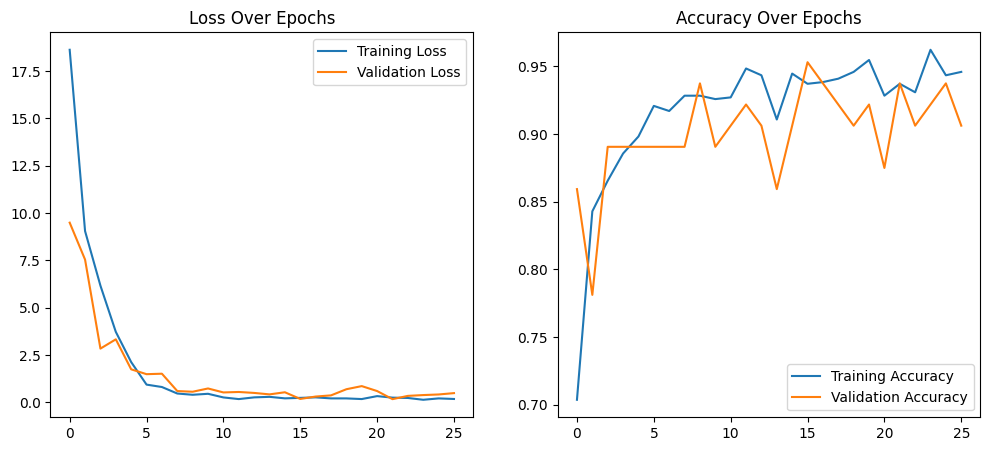


Final Training Loss: 0.1845
Final Validation Loss: 0.4940
Final Training Accuracy: 0.9460
Final Validation Accuracy: 0.9062
4/4 [==============================] - 2s 450ms/step - loss: 0.2502 - accuracy: 0.9320
Test Loss: 0.2501858174800873, Test Accuracy: 0.9320388436317444


In [58]:
epochs = 100

results_df, model_vgg_16_1 = full_model_evaluation(
    create_model_func=lambda: create_pretrained_model_with_augmentation('ResNet50', input_shape=(256, 256, 3), num_classes=4),
    config_description="ResNet50 trial",
    train_dataset=train_dataset_nopreproc,
    val_dataset=val_dataset_nopreproc,
    test_dataset=test_dataset_nopreproc,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df,
    callbacks=[early_stopping]
)

9406464/9406464 [==============================] - 0s 0us/step
Base Model Summary:
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_20[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                               

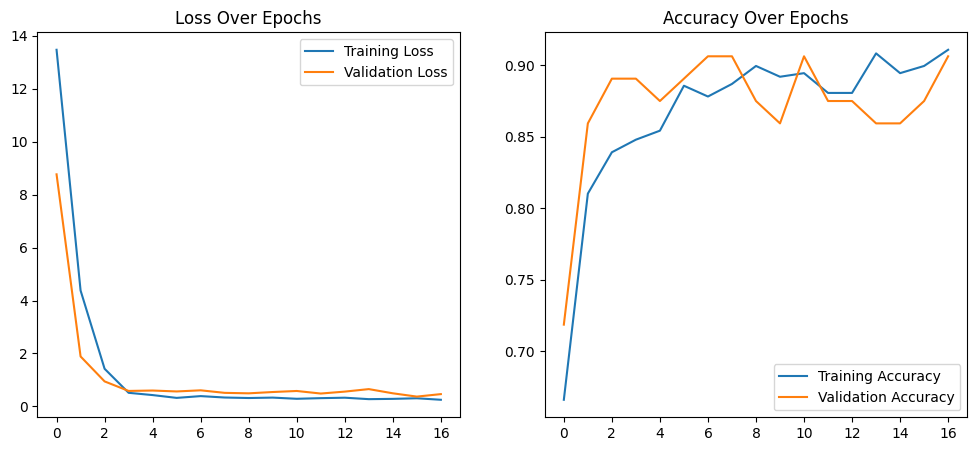


Final Training Loss: 0.2488
Final Validation Loss: 0.4628
Final Training Accuracy: 0.9108
Final Validation Accuracy: 0.9062
4/4 [==============================] - 1s 454ms/step - loss: 0.2488 - accuracy: 0.9126
Test Loss: 0.2487722933292389, Test Accuracy: 0.9126213788986206


In [59]:
epochs = 100

results_df, model_vgg_16_1 = full_model_evaluation(
    create_model_func=lambda: create_pretrained_model_with_augmentation('MobileNetV2', input_shape=(256, 256, 3), num_classes=4),
    config_description="MobileNetV2 trial",
    train_dataset=train_dataset_nopreproc,
    val_dataset=val_dataset_nopreproc,
    test_dataset=test_dataset_nopreproc,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df,
    callbacks=[early_stopping]
)

87910968/87910968 [==============================] - 1s 0us/step
Base Model Summary:
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 127, 127, 32)         864       ['input_22[0][0]']            
                                                                                                  
 batch_normalization_40 (Ba  (None, 127, 127, 32)         96        ['conv2d_6[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 a

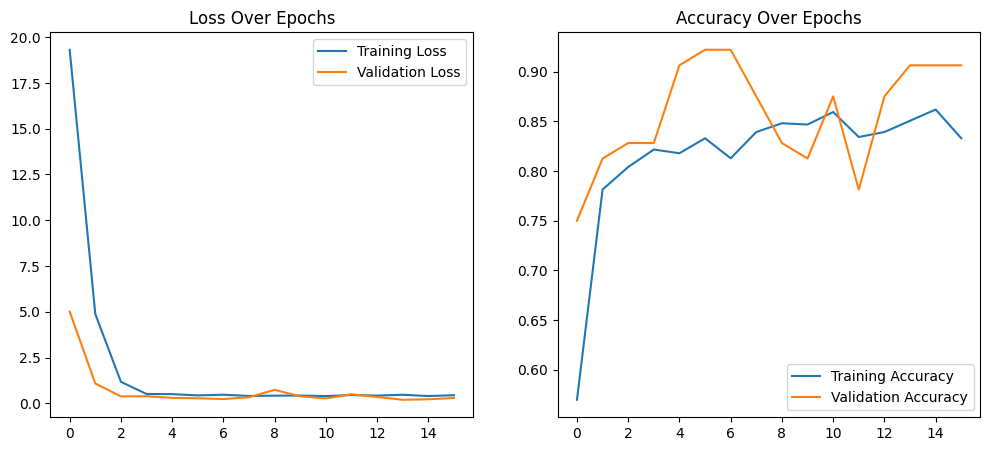


Final Training Loss: 0.4388
Final Validation Loss: 0.2893
Final Training Accuracy: 0.8329
Final Validation Accuracy: 0.9062
4/4 [==============================] - 2s 728ms/step - loss: 0.3121 - accuracy: 0.8738
Test Loss: 0.3120919466018677, Test Accuracy: 0.8737863898277283


In [60]:
epochs = 100

results_df, model_InceptionV3_1 = full_model_evaluation(
    create_model_func=lambda: create_pretrained_model_with_augmentation('InceptionV3', input_shape=(256, 256, 3), num_classes=4),
    config_description="InceptionV3 trial",
    train_dataset=train_dataset_nopreproc,
    val_dataset=val_dataset_nopreproc,
    test_dataset=test_dataset_nopreproc,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df,
    callbacks=[early_stopping]
)

16705208/16705208 [==============================] - 0s 0us/step
Base Model Summary:
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_24[0][0]']            
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  


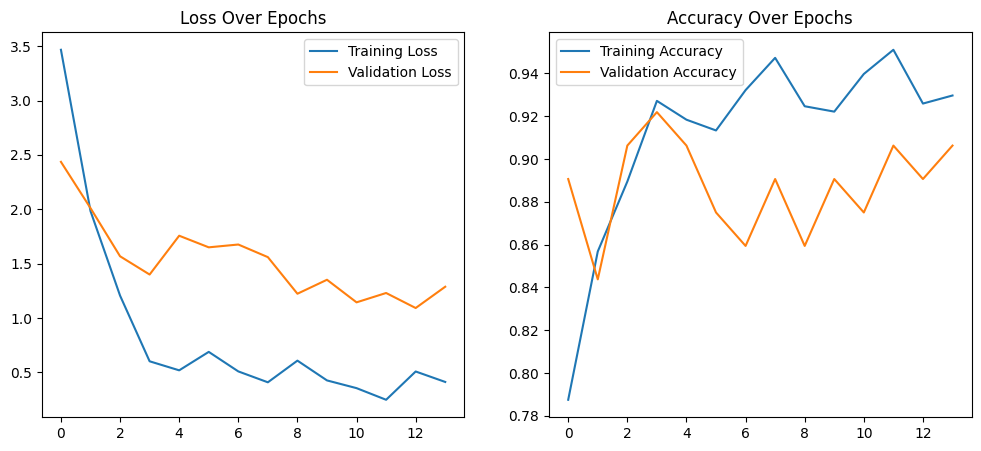


Final Training Loss: 0.4129
Final Validation Loss: 1.2881
Final Training Accuracy: 0.9296
Final Validation Accuracy: 0.9062
4/4 [==============================] - 1s 305ms/step - loss: 0.8730 - accuracy: 0.9223
Test Loss: 0.8730142116546631, Test Accuracy: 0.9223300814628601


In [61]:
epochs = 100

results_df, model_EfficientNetB0_1 = full_model_evaluation(
    create_model_func=lambda: create_pretrained_model_with_augmentation('EfficientNetB0', input_shape=(256, 256, 3), num_classes=4),
    config_description="EfficientNetB0 trial",
    train_dataset=train_dataset_nopreproc,
    val_dataset=val_dataset_nopreproc,
    test_dataset=test_dataset_nopreproc,
    epochs=epochs,
    batch_size=batch_size,
    results_df=results_df,
    callbacks=[early_stopping]
)

In [62]:
results_df

,Configuration,Final Train Loss,Final Validation Loss,Final Train Accuracy,Final Validation Accuracy,Test Loss,Test Accuracy,Total Training Time (s),Average Time per Epoch (s)
0,Baseline Model,0.000719,3.298196,1.000000,0.609375,3.754167,0.466019,133.340943,1.333409
1,Model with L1 Regularization (0.001),4.019690,4.199212,0.232412,0.250000,4.199183,0.242718,157.656868,1.576569
2,Model with L1 Regularization (0.01),28.146200,30.211891,0.201005,0.281250,30.211897,0.252427,150.499986,1.505000
3,Model with L2 Regularization (0.001),3.991182,4.155935,0.238693,0.281250,4.156052,0.252427,148.454952,1.484550
4,Model with L2 Regularization (0.01),28.139238,30.197332,0.218593,0.203125,30.197268,0.252427,148.498567,1.484986
5,Model with batch normalization,0.511984,1.664261,0.802764,0.515625,1.785823,0.495146,196.073616,1.960736
6,Model with dropout (0.5),1.387294,1.386011,0.250000,0.281250,1.386278,0.252427,205.491993,2.054920
7,Model with dropout (0.35),1.387076,1.385794,0.256281,0.281250,1.386235,0.252427,205.778939,2.057789
8,Model with dropout (0.2),1.101971,1.289256,0.459799,0.343750,1.320711,0.320388,204.991889,2.049919
9,Model with Early Stopping (patience 10),0.969935,1.586537,0.576633,0.343750,1.139412,0.524272,39.110418,1.629601


#### Results of Transfer Learning

Five pre-trained architectures were applied to train the classification model:
1. VGG16
2. ResNet50
3. MobileNetV2
4. InceptionV3
5. EfficientNetB0

**Results**
All of the models achieved very high scores comparing to all previously applied architectures (DNNs and CNNs) achieved very high score of around 90% validation accuracy. In terms of test accuracy every pre-trained model but *InceptionV3* achieved score above 91%.

The best model in terms of test accuracy is *ResNet50* that achieved 93% of test accuracy. This architecture may outperform the other ones due to its depth of hidden layers and its Residual Blocks architecture that allows it to train comparably fast to other, less deep models, and still achieve very satisfactory results.

In general, using pre-trained models as features-extractors and only training Dense Classification Layers works much better on this size of the dataset, than training a CNN model from scratch to allow it to correctly extract features with KNN kernels before classification.

It is crucial to mention that all models were upgrade with training data augmentation layer as it proved to increase the performance of models in the previous stages of the project.

At this point, it is also worth mentioning the difference in training time -- the pre-trained models, when applied in Transfer Learning have explicitly show higher training time per epoch, which is understandable due to their advanced structure. However, for the small size of dataset at hand, this is a fair trade-off, as these models showed to achieve significantly better results then previously applied DNNs and CNNs.

**Conclusion**

After reviewing transfer learning with most popular CNN-based architectures, it can be concluded with high confidence that model based on ResNet50, adapted to classificaiton of 4 classes of business photos from Yelp, can be implemented in the product and help in identification of semantic meaning of pictures, at least for the 4 pre-defined categories: Food, Drink, Interior and Exterior.

---
### Conclusions & Recommendations

After training and evaluation 20 Deep Learning architectures for image classification on four classes: Food, Drink, Interior and Exterior, we came to the conclusion that model trained on the basis of pre-trained ResNet50 architectures performs good enough to be implemented in the product, as well as for analytical purposes.

93% of test accuracy indicates that the model very rarely commits mistakes when recognising categories of images. Also, it is fair to conclude that 7% of total misclassified test samples can be caused by low quality of pictures posted by clients as well as inconsitencies in the dataset.

It is also crucial to mention that the size of the dataset used for model training and classification was relatively small (only 1024 photos). Even though, thanks to pre-trained models, we were able to achieve very satisfactory results.

As for the next steps, it is recommended to implement the model in two ways:
1. Implement the best performing model into the product to enchance user experience -- thanks to implementation of automatic classification based on the DL model predictions, more photos from reviews of local businesses will be instantly classified into categories. From the user perspective, it will provide way more legitimate pictures of each category, making it easier to assess specific attributes of each business: how the place looks from inside, outside, as well as, how food and drinks are served. When integrated with buttons allowing to automatically filter by image category, users will be able to seemlessly assess whether they are interested in going to a restaurant or not. Such a features will allow Yelp's business to gain significant competitive advantage by providing users with unique user experience.
2. Analytical Implementation -- thanks to automatic classification of images posted by customers, the analytical team will be able to easier analyse the images and identify various patterns among restaurants present on the Yelp platform. For example, based on the interior and exterior pictures analytical team, by applying specific techniques (e.g. ML-based object detection and object recognition), might approach understanding the relation between levels of reviews (high, medium, low) and the characteristics of images posted by customers. This is just one example, but the analytical possibilities are endless.

### Further Development

The benefits from integrating such model into the Yelp platform and Yelp's operations, do not end here. It is crucial to mention that implementation of DL-based image classification in the long run will generate more, confidently categorized data, which will open more possibilities.

Further Model Improvement, and tackling the training data deficit issue -- thanks to accumnulation of more classified data, Yelp will be able to re-train current models:
  - For pre-trained architectures such as ResNet50-based models, it will further allow to achieve even higher accuracy score, that will lead to even better customer experience due to lower number of misclassified pictures.
  - Increasing the training dataset size might create opportunities to train simpler, more computationally efficient models that in the long run will infer the predictions fasters and might help in cost optimization of inference of categories of new pictures posted by Yelp's users. Taking into the account Yelp's scale of operation, exploring more computationally efficient architectures, might save significant money, compared to complex CNN-based models.